In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

from sklearn import metrics
from torchvision import datasets, transforms

# Debugger 
from IPython.core.debugger import set_trace

%matplotlib inline

In [18]:
# Config contains hyperparameter values to be used in the model
config = {
          'batch_size':64,          # Training batch size
          'cuda': {'use_cuda':False,  # Use_cuda=True: use GPU
                   'device_idx': 0}, # Select gpu index: 0,1,2,3
          'log_interval':100,         # How often to dislay (batch) loss during training
          'epochs': 1000,              # Number of epochs
          'learningRate': 0.001,     # learning rate to the optimizer
          'momentum': 0.9,            # momentum in the SGD optimizer
          'use_augmentation': True,  # Use augmentation
          'weight_decay': 0.0001     # weight_decay value
         }

In [3]:
# Transformation on the data
# If use_augmentation is set to True, randomcropping and horizontal flips are used
# else, we only transform to torch tensors and normalize with standard variables

if config['use_augmentation']:
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), 
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
else:
    train_transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
    
print(train_transform)
print(val_transform)


Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)
Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)


In [4]:
data_path        = './data'

train_data       = datasets.CIFAR10(root=data_path, download=True, train=True, transform=train_transform)
val_data         = datasets.CIFAR10(root=data_path, download=True, train=False, transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=config['batch_size'], shuffle=True, num_workers=2)
val_dataloader   = torch.utils.data.DataLoader(dataset=val_data, batch_size=config['batch_size'], shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


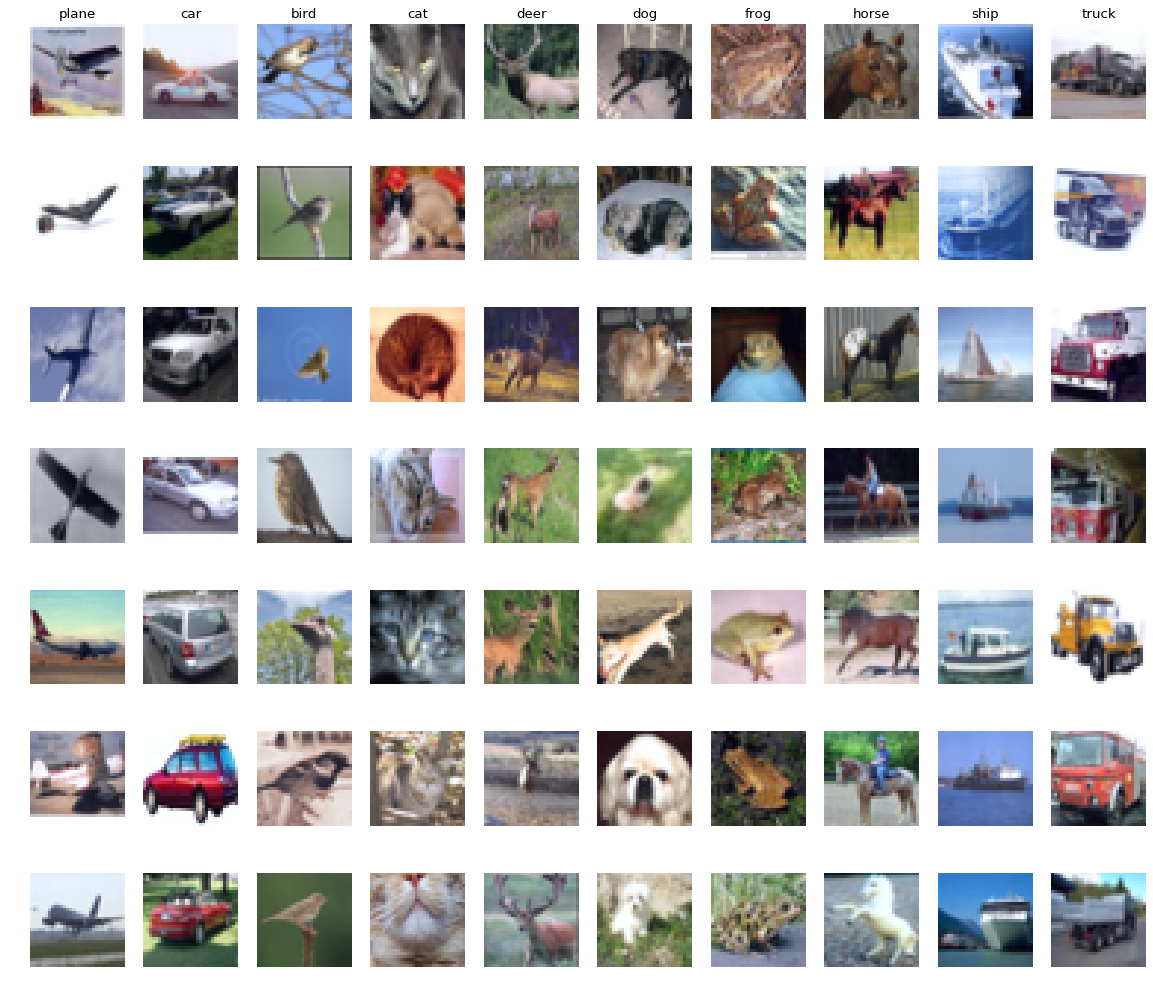

In [5]:
# Visualize a sample of random images

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
plt.figure(figsize=(18, 16), dpi=80)
labels = np.array([x[1] for x in val_data])

for y, cls in enumerate(classes):              
    idxs = np.flatnonzero(labels == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        img = (val_data[idx][0]*0.2 + 0.5)*255
        img = img.permute(1, 2, 0).numpy()
        img = np.minimum(img, 255)
        plt.imshow(img.astype(np.uint8))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
# torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

# wout = ((win - F + 2P) / S ) + 1

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        # in_channels = 3, out_channels = 18
        # Size = 32x32
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, stride=1, padding=1)
        
        # channels = same, 
        # Size = 16x16
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # in_channels = 18, out_channels = 32
        # Size = 16x16
        self.conv2 = nn.Conv2d(12, 32, kernel_size=3, stride=1, padding=1)
        
        #channels = same, 
        # Size = 8x8
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        
        # Input features = 1024
        # Output features = 128
        self.fc1   = nn.Linear(8 * 8 * 32, 128)
        
        self.fc2   = nn.Linear(128, 64)
        
        self.fc3   = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        
        x = F.relu(self.fc3(x))
        
        return x
        
        

In [12]:
model = NeuralNetwork()

def cost(predicted, labels):
        loss = F.cross_entropy(input=predicted, target=labels)
        return loss
        

In [14]:
optimizer = optim.SGD(model.parameters(), lr = config['learningRate'], momentum = config['momentum'])

def run_epoch(model,epoch , data_loader, optimizer, is_training, config):
    
    if is_training:
        model.train()
    else:
        model.eval()
    
    total_loss = 0
    correct    = 0
    
    for batch_idx, data_batch in enumerate(data_loader):
        
        # data_batch returns a tuple, first element is data, second is label
        image  = data_batch[0]
        label = data_batch[1]
        
        if not is_training:
            with torch.no_grad():
                
                predicted  = model.forward(image)
                loss       = cost(predicted, label)
                
                total_loss+= loss.item()
                
        elif is_training:
            
            predicted      = model.forward(image)
            loss           = cost(predicted, label)
            total_loss    += loss.item()
            
            # Null out the gradients, calculate new gradients in backpropagaton and step with SGD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        
        predicted_label = predicted.max(1, keepdim=True)[1][:, 0]
        correct        += predicted_label.eq(label).cpu().sum().numpy()

        batchSize = len(labels)
        if batch_idx % config['log_interval'] == 0:
            print('Epoch: {}\nLoss: {}'.format(epoch, loss))
            print(f'Epoch={epoch} | {batch_idx/len(data_loader)*100:.2f}% | loss = {loss/batchSize:.5f}')
            
            
    
    loss_avg = total_loss / len(data_loader)
    accuracy = correct / len(data_loader.dataset)
        
    return loss_avg, accuracy

In [19]:
# training the model
train_loss = np.zeros(shape=config['epochs'])
train_acc  = np.zeros(shape=config['epochs'])
val_loss   = np.zeros(shape=config['epochs'])
val_acc    = np.zeros(shape=config['epochs'])


for epoch in range(config['epochs']):
    
    train_loss[epoch], train_acc[epoch] = run_epoch(model, epoch, train_dataloader, optimizer, is_training=True, config=config)
    val_loss[epoch], val_acc[epoch] = run_epoch(model, epoch, val_dataloader, optimizer, is_training=False, config=config)
    

Epoch: 0
Loss: 1.2294275760650635
Epoch=0 | 0.00% | loss = 0.00012
Epoch: 0
Loss: 1.4600858688354492
Epoch=0 | 12.79% | loss = 0.00015
Epoch: 0
Loss: 1.236460566520691
Epoch=0 | 25.58% | loss = 0.00012
Epoch: 0
Loss: 1.4562904834747314
Epoch=0 | 38.36% | loss = 0.00015
Epoch: 0
Loss: 1.6469125747680664
Epoch=0 | 51.15% | loss = 0.00016
Epoch: 0
Loss: 1.2528929710388184
Epoch=0 | 63.94% | loss = 0.00013
Epoch: 0
Loss: 1.4624886512756348
Epoch=0 | 76.73% | loss = 0.00015
Epoch: 0
Loss: 1.1887383460998535
Epoch=0 | 89.51% | loss = 0.00012
Epoch: 0
Loss: 1.1436443328857422
Epoch=0 | 0.00% | loss = 0.00011
Epoch: 0
Loss: 1.3420419692993164
Epoch=0 | 63.69% | loss = 0.00013
Epoch: 1
Loss: 1.046255350112915
Epoch=1 | 0.00% | loss = 0.00010
Epoch: 1
Loss: 1.1125366687774658
Epoch=1 | 12.79% | loss = 0.00011
Epoch: 1
Loss: 1.2564318180084229
Epoch=1 | 25.58% | loss = 0.00013
Epoch: 1
Loss: 1.3496218919754028
Epoch=1 | 38.36% | loss = 0.00013
Epoch: 1
Loss: 1.295074224472046
Epoch=1 | 51.15% | l

Epoch: 12
Loss: 0.8289167284965515
Epoch=12 | 12.79% | loss = 0.00008
Epoch: 12
Loss: 0.9213384985923767
Epoch=12 | 25.58% | loss = 0.00009
Epoch: 12
Loss: 0.968317449092865
Epoch=12 | 38.36% | loss = 0.00010
Epoch: 12
Loss: 0.8055250644683838
Epoch=12 | 51.15% | loss = 0.00008
Epoch: 12
Loss: 0.9188820123672485
Epoch=12 | 63.94% | loss = 0.00009
Epoch: 12
Loss: 0.896238386631012
Epoch=12 | 76.73% | loss = 0.00009
Epoch: 12
Loss: 0.9573381543159485
Epoch=12 | 89.51% | loss = 0.00010
Epoch: 12
Loss: 0.9335395693778992
Epoch=12 | 0.00% | loss = 0.00009
Epoch: 12
Loss: 1.0601686239242554
Epoch=12 | 63.69% | loss = 0.00011
Epoch: 13
Loss: 0.7039629220962524
Epoch=13 | 0.00% | loss = 0.00007
Epoch: 13
Loss: 1.0867674350738525
Epoch=13 | 12.79% | loss = 0.00011
Epoch: 13
Loss: 0.9038209915161133
Epoch=13 | 25.58% | loss = 0.00009
Epoch: 13
Loss: 0.9031656384468079
Epoch=13 | 38.36% | loss = 0.00009
Epoch: 13
Loss: 0.8065420985221863
Epoch=13 | 51.15% | loss = 0.00008
Epoch: 13
Loss: 1.055921

Epoch: 23
Loss: 0.8310244083404541
Epoch=23 | 63.69% | loss = 0.00008
Epoch: 24
Loss: 0.6761116981506348
Epoch=24 | 0.00% | loss = 0.00007
Epoch: 24
Loss: 0.7295103073120117
Epoch=24 | 12.79% | loss = 0.00007
Epoch: 24
Loss: 0.8169551491737366
Epoch=24 | 25.58% | loss = 0.00008
Epoch: 24
Loss: 0.6457616686820984
Epoch=24 | 38.36% | loss = 0.00006
Epoch: 24
Loss: 1.0042600631713867
Epoch=24 | 51.15% | loss = 0.00010
Epoch: 24
Loss: 0.7915545105934143
Epoch=24 | 63.94% | loss = 0.00008
Epoch: 24
Loss: 0.7435214519500732
Epoch=24 | 76.73% | loss = 0.00007
Epoch: 24
Loss: 0.8804599642753601
Epoch=24 | 89.51% | loss = 0.00009
Epoch: 24
Loss: 0.9160091876983643
Epoch=24 | 0.00% | loss = 0.00009
Epoch: 24
Loss: 0.8395894765853882
Epoch=24 | 63.69% | loss = 0.00008
Epoch: 25
Loss: 0.728935718536377
Epoch=25 | 0.00% | loss = 0.00007
Epoch: 25
Loss: 0.9605717658996582
Epoch=25 | 12.79% | loss = 0.00010
Epoch: 25
Loss: 0.8638018369674683
Epoch=25 | 25.58% | loss = 0.00009
Epoch: 25
Loss: 0.742084

Epoch: 35
Loss: 0.9950734972953796
Epoch=35 | 89.51% | loss = 0.00010
Epoch: 35
Loss: 0.7990074157714844
Epoch=35 | 0.00% | loss = 0.00008
Epoch: 35
Loss: 0.7402102947235107
Epoch=35 | 63.69% | loss = 0.00007
Epoch: 36
Loss: 0.8240454196929932
Epoch=36 | 0.00% | loss = 0.00008
Epoch: 36
Loss: 0.7751016616821289
Epoch=36 | 12.79% | loss = 0.00008
Epoch: 36
Loss: 0.8748223781585693
Epoch=36 | 25.58% | loss = 0.00009
Epoch: 36
Loss: 0.6707373261451721
Epoch=36 | 38.36% | loss = 0.00007
Epoch: 36
Loss: 0.5737495422363281
Epoch=36 | 51.15% | loss = 0.00006
Epoch: 36
Loss: 0.7215331196784973
Epoch=36 | 63.94% | loss = 0.00007
Epoch: 36
Loss: 0.6965894103050232
Epoch=36 | 76.73% | loss = 0.00007
Epoch: 36
Loss: 0.6278689503669739
Epoch=36 | 89.51% | loss = 0.00006
Epoch: 36
Loss: 0.8503690361976624
Epoch=36 | 0.00% | loss = 0.00009
Epoch: 36
Loss: 0.8072453737258911
Epoch=36 | 63.69% | loss = 0.00008
Epoch: 37
Loss: 0.9407185316085815
Epoch=37 | 0.00% | loss = 0.00009
Epoch: 37
Loss: 0.844963

Epoch: 47
Loss: 0.7592281699180603
Epoch=47 | 63.94% | loss = 0.00008
Epoch: 47
Loss: 0.5983507633209229
Epoch=47 | 76.73% | loss = 0.00006
Epoch: 47
Loss: 0.5773472189903259
Epoch=47 | 89.51% | loss = 0.00006
Epoch: 47
Loss: 0.8316258192062378
Epoch=47 | 0.00% | loss = 0.00008
Epoch: 47
Loss: 0.7583902478218079
Epoch=47 | 63.69% | loss = 0.00008
Epoch: 48
Loss: 0.5853704214096069
Epoch=48 | 0.00% | loss = 0.00006
Epoch: 48
Loss: 0.5164970755577087
Epoch=48 | 12.79% | loss = 0.00005
Epoch: 48
Loss: 0.6534203886985779
Epoch=48 | 25.58% | loss = 0.00007
Epoch: 48
Loss: 0.6778445243835449
Epoch=48 | 38.36% | loss = 0.00007
Epoch: 48
Loss: 0.62253737449646
Epoch=48 | 51.15% | loss = 0.00006
Epoch: 48
Loss: 0.6875330209732056
Epoch=48 | 63.94% | loss = 0.00007
Epoch: 48
Loss: 0.5867451429367065
Epoch=48 | 76.73% | loss = 0.00006
Epoch: 48
Loss: 0.9989203214645386
Epoch=48 | 89.51% | loss = 0.00010
Epoch: 48
Loss: 0.7699259519577026
Epoch=48 | 0.00% | loss = 0.00008
Epoch: 48
Loss: 0.8027789

Epoch: 59
Loss: 0.5679098963737488
Epoch=59 | 38.36% | loss = 0.00006
Epoch: 59
Loss: 0.6811495423316956
Epoch=59 | 51.15% | loss = 0.00007
Epoch: 59
Loss: 0.40353113412857056
Epoch=59 | 63.94% | loss = 0.00004
Epoch: 59
Loss: 0.8338141441345215
Epoch=59 | 76.73% | loss = 0.00008
Epoch: 59
Loss: 0.7430123090744019
Epoch=59 | 89.51% | loss = 0.00007
Epoch: 59
Loss: 0.8532394170761108
Epoch=59 | 0.00% | loss = 0.00009
Epoch: 59
Loss: 0.7226077914237976
Epoch=59 | 63.69% | loss = 0.00007
Epoch: 60
Loss: 0.7884786128997803
Epoch=60 | 0.00% | loss = 0.00008
Epoch: 60
Loss: 0.5623135566711426
Epoch=60 | 12.79% | loss = 0.00006
Epoch: 60
Loss: 0.781964123249054
Epoch=60 | 25.58% | loss = 0.00008
Epoch: 60
Loss: 0.5734236240386963
Epoch=60 | 38.36% | loss = 0.00006
Epoch: 60
Loss: 0.6476390957832336
Epoch=60 | 51.15% | loss = 0.00006
Epoch: 60
Loss: 0.5444328784942627
Epoch=60 | 63.94% | loss = 0.00005
Epoch: 60
Loss: 0.7568016648292542
Epoch=60 | 76.73% | loss = 0.00008
Epoch: 60
Loss: 0.6355

Epoch: 71
Loss: 0.608797550201416
Epoch=71 | 12.79% | loss = 0.00006
Epoch: 71
Loss: 0.7194384336471558
Epoch=71 | 25.58% | loss = 0.00007
Epoch: 71
Loss: 0.6031947731971741
Epoch=71 | 38.36% | loss = 0.00006
Epoch: 71
Loss: 0.6185281276702881
Epoch=71 | 51.15% | loss = 0.00006
Epoch: 71
Loss: 0.6049464344978333
Epoch=71 | 63.94% | loss = 0.00006
Epoch: 71
Loss: 0.5812612175941467
Epoch=71 | 76.73% | loss = 0.00006
Epoch: 71
Loss: 0.6170209646224976
Epoch=71 | 89.51% | loss = 0.00006
Epoch: 71
Loss: 0.7727537751197815
Epoch=71 | 0.00% | loss = 0.00008
Epoch: 71
Loss: 0.778536319732666
Epoch=71 | 63.69% | loss = 0.00008
Epoch: 72
Loss: 0.4803547263145447
Epoch=72 | 0.00% | loss = 0.00005
Epoch: 72
Loss: 0.49664831161499023
Epoch=72 | 12.79% | loss = 0.00005
Epoch: 72
Loss: 0.4200693964958191
Epoch=72 | 25.58% | loss = 0.00004
Epoch: 72
Loss: 0.5330743789672852
Epoch=72 | 38.36% | loss = 0.00005
Epoch: 72
Loss: 0.6994065046310425
Epoch=72 | 51.15% | loss = 0.00007
Epoch: 72
Loss: 0.54152

Epoch: 82
Loss: 0.6900104284286499
Epoch=82 | 63.69% | loss = 0.00007
Epoch: 83
Loss: 0.8280481100082397
Epoch=83 | 0.00% | loss = 0.00008
Epoch: 83
Loss: 0.8841991424560547
Epoch=83 | 12.79% | loss = 0.00009
Epoch: 83
Loss: 0.5907697677612305
Epoch=83 | 25.58% | loss = 0.00006
Epoch: 83
Loss: 0.4537466764450073
Epoch=83 | 38.36% | loss = 0.00005
Epoch: 83
Loss: 0.5400048494338989
Epoch=83 | 51.15% | loss = 0.00005
Epoch: 83
Loss: 0.6417114734649658
Epoch=83 | 63.94% | loss = 0.00006
Epoch: 83
Loss: 0.6947096586227417
Epoch=83 | 76.73% | loss = 0.00007
Epoch: 83
Loss: 0.6343972682952881
Epoch=83 | 89.51% | loss = 0.00006
Epoch: 83
Loss: 0.8037958145141602
Epoch=83 | 0.00% | loss = 0.00008
Epoch: 83
Loss: 0.7276915907859802
Epoch=83 | 63.69% | loss = 0.00007
Epoch: 84
Loss: 0.8551191091537476
Epoch=84 | 0.00% | loss = 0.00009
Epoch: 84
Loss: 0.7696654200553894
Epoch=84 | 12.79% | loss = 0.00008
Epoch: 84
Loss: 0.5721796154975891
Epoch=84 | 25.58% | loss = 0.00006
Epoch: 84
Loss: 0.65262

Epoch: 94
Loss: 0.6886212825775146
Epoch=94 | 89.51% | loss = 0.00007
Epoch: 94
Loss: 0.9518808126449585
Epoch=94 | 0.00% | loss = 0.00010
Epoch: 94
Loss: 0.8238618969917297
Epoch=94 | 63.69% | loss = 0.00008
Epoch: 95
Loss: 0.6029849052429199
Epoch=95 | 0.00% | loss = 0.00006
Epoch: 95
Loss: 0.8561362028121948
Epoch=95 | 12.79% | loss = 0.00009
Epoch: 95
Loss: 0.5255284905433655
Epoch=95 | 25.58% | loss = 0.00005
Epoch: 95
Loss: 0.335620641708374
Epoch=95 | 38.36% | loss = 0.00003
Epoch: 95
Loss: 0.49801507592201233
Epoch=95 | 51.15% | loss = 0.00005
Epoch: 95
Loss: 0.5180217027664185
Epoch=95 | 63.94% | loss = 0.00005
Epoch: 95
Loss: 0.5296083688735962
Epoch=95 | 76.73% | loss = 0.00005
Epoch: 95
Loss: 0.5494077205657959
Epoch=95 | 89.51% | loss = 0.00005
Epoch: 95
Loss: 0.8644770383834839
Epoch=95 | 0.00% | loss = 0.00009
Epoch: 95
Loss: 0.7343404293060303
Epoch=95 | 63.69% | loss = 0.00007
Epoch: 96
Loss: 0.4184436798095703
Epoch=96 | 0.00% | loss = 0.00004
Epoch: 96
Loss: 0.558729

Epoch: 106
Loss: 0.725614070892334
Epoch=106 | 38.36% | loss = 0.00007
Epoch: 106
Loss: 0.2619679570198059
Epoch=106 | 51.15% | loss = 0.00003
Epoch: 106
Loss: 0.7134714126586914
Epoch=106 | 63.94% | loss = 0.00007
Epoch: 106
Loss: 0.4992403984069824
Epoch=106 | 76.73% | loss = 0.00005
Epoch: 106
Loss: 0.48012202978134155
Epoch=106 | 89.51% | loss = 0.00005
Epoch: 106
Loss: 0.8331011533737183
Epoch=106 | 0.00% | loss = 0.00008
Epoch: 106
Loss: 0.7414037585258484
Epoch=106 | 63.69% | loss = 0.00007
Epoch: 107
Loss: 0.4609869122505188
Epoch=107 | 0.00% | loss = 0.00005
Epoch: 107
Loss: 0.3575262725353241
Epoch=107 | 12.79% | loss = 0.00004
Epoch: 107
Loss: 0.6178535223007202
Epoch=107 | 25.58% | loss = 0.00006
Epoch: 107
Loss: 0.5531179308891296
Epoch=107 | 38.36% | loss = 0.00006
Epoch: 107
Loss: 0.4813636541366577
Epoch=107 | 51.15% | loss = 0.00005
Epoch: 107
Loss: 0.516665518283844
Epoch=107 | 63.94% | loss = 0.00005
Epoch: 107
Loss: 0.45614081621170044
Epoch=107 | 76.73% | loss = 0.

Epoch: 117
Loss: 0.8453885316848755
Epoch=117 | 0.00% | loss = 0.00008
Epoch: 117
Loss: 0.7167319059371948
Epoch=117 | 63.69% | loss = 0.00007
Epoch: 118
Loss: 0.4840461015701294
Epoch=118 | 0.00% | loss = 0.00005
Epoch: 118
Loss: 0.4425815939903259
Epoch=118 | 12.79% | loss = 0.00004
Epoch: 118
Loss: 0.5863874554634094
Epoch=118 | 25.58% | loss = 0.00006
Epoch: 118
Loss: 0.6308385133743286
Epoch=118 | 38.36% | loss = 0.00006
Epoch: 118
Loss: 0.4447045922279358
Epoch=118 | 51.15% | loss = 0.00004
Epoch: 118
Loss: 0.3616897761821747
Epoch=118 | 63.94% | loss = 0.00004
Epoch: 118
Loss: 0.7369571328163147
Epoch=118 | 76.73% | loss = 0.00007
Epoch: 118
Loss: 0.7726141810417175
Epoch=118 | 89.51% | loss = 0.00008
Epoch: 118
Loss: 0.8099673986434937
Epoch=118 | 0.00% | loss = 0.00008
Epoch: 118
Loss: 0.750558614730835
Epoch=118 | 63.69% | loss = 0.00008
Epoch: 119
Loss: 0.45195770263671875
Epoch=119 | 0.00% | loss = 0.00005
Epoch: 119
Loss: 0.7739230990409851
Epoch=119 | 12.79% | loss = 0.00

Epoch: 129
Loss: 0.4112333655357361
Epoch=129 | 38.36% | loss = 0.00004
Epoch: 129
Loss: 0.5426305532455444
Epoch=129 | 51.15% | loss = 0.00005
Epoch: 129
Loss: 0.587928831577301
Epoch=129 | 63.94% | loss = 0.00006
Epoch: 129
Loss: 0.418953001499176
Epoch=129 | 76.73% | loss = 0.00004
Epoch: 129
Loss: 0.3234860301017761
Epoch=129 | 89.51% | loss = 0.00003
Epoch: 129
Loss: 0.812766432762146
Epoch=129 | 0.00% | loss = 0.00008
Epoch: 129
Loss: 0.7629259824752808
Epoch=129 | 63.69% | loss = 0.00008
Epoch: 130
Loss: 0.6366870403289795
Epoch=130 | 0.00% | loss = 0.00006
Epoch: 130
Loss: 0.6478466987609863
Epoch=130 | 12.79% | loss = 0.00006
Epoch: 130
Loss: 0.5632236003875732
Epoch=130 | 25.58% | loss = 0.00006
Epoch: 130
Loss: 0.5974772572517395
Epoch=130 | 38.36% | loss = 0.00006
Epoch: 130
Loss: 0.6646494269371033
Epoch=130 | 51.15% | loss = 0.00007
Epoch: 130
Loss: 0.5796569585800171
Epoch=130 | 63.94% | loss = 0.00006
Epoch: 130
Loss: 0.5314851403236389
Epoch=130 | 76.73% | loss = 0.000

Epoch: 140
Loss: 0.8416908383369446
Epoch=140 | 0.00% | loss = 0.00008
Epoch: 140
Loss: 0.8699859380722046
Epoch=140 | 63.69% | loss = 0.00009
Epoch: 141
Loss: 0.5283675789833069
Epoch=141 | 0.00% | loss = 0.00005
Epoch: 141
Loss: 0.629152774810791
Epoch=141 | 12.79% | loss = 0.00006
Epoch: 141
Loss: 0.49796611070632935
Epoch=141 | 25.58% | loss = 0.00005
Epoch: 141
Loss: 0.525919497013092
Epoch=141 | 38.36% | loss = 0.00005
Epoch: 141
Loss: 0.37528109550476074
Epoch=141 | 51.15% | loss = 0.00004
Epoch: 141
Loss: 0.46646687388420105
Epoch=141 | 63.94% | loss = 0.00005
Epoch: 141
Loss: 0.7791343331336975
Epoch=141 | 76.73% | loss = 0.00008
Epoch: 141
Loss: 0.33773210644721985
Epoch=141 | 89.51% | loss = 0.00003
Epoch: 141
Loss: 0.8381475806236267
Epoch=141 | 0.00% | loss = 0.00008
Epoch: 141
Loss: 0.7521013617515564
Epoch=141 | 63.69% | loss = 0.00008
Epoch: 142
Loss: 0.5521194934844971
Epoch=142 | 0.00% | loss = 0.00006
Epoch: 142
Loss: 0.3392881155014038
Epoch=142 | 12.79% | loss = 0.

Epoch: 152
Loss: 0.5576744079589844
Epoch=152 | 25.58% | loss = 0.00006
Epoch: 152
Loss: 0.40516993403434753
Epoch=152 | 38.36% | loss = 0.00004
Epoch: 152
Loss: 0.6127363443374634
Epoch=152 | 51.15% | loss = 0.00006
Epoch: 152
Loss: 0.4774464964866638
Epoch=152 | 63.94% | loss = 0.00005
Epoch: 152
Loss: 0.6929892301559448
Epoch=152 | 76.73% | loss = 0.00007
Epoch: 152
Loss: 0.4272235035896301
Epoch=152 | 89.51% | loss = 0.00004
Epoch: 152
Loss: 0.794837236404419
Epoch=152 | 0.00% | loss = 0.00008
Epoch: 152
Loss: 0.7490968704223633
Epoch=152 | 63.69% | loss = 0.00007
Epoch: 153
Loss: 0.6329011917114258
Epoch=153 | 0.00% | loss = 0.00006
Epoch: 153
Loss: 0.35080355405807495
Epoch=153 | 12.79% | loss = 0.00004
Epoch: 153
Loss: 0.4361017346382141
Epoch=153 | 25.58% | loss = 0.00004
Epoch: 153
Loss: 0.46742337942123413
Epoch=153 | 38.36% | loss = 0.00005
Epoch: 153
Loss: 0.39315158128738403
Epoch=153 | 51.15% | loss = 0.00004
Epoch: 153
Loss: 0.2819187045097351
Epoch=153 | 63.94% | loss =

Epoch: 163
Loss: 0.915702223777771
Epoch=163 | 76.73% | loss = 0.00009
Epoch: 163
Loss: 0.5237952470779419
Epoch=163 | 89.51% | loss = 0.00005
Epoch: 163
Loss: 0.7378215789794922
Epoch=163 | 0.00% | loss = 0.00007
Epoch: 163
Loss: 0.7912169694900513
Epoch=163 | 63.69% | loss = 0.00008
Epoch: 164
Loss: 0.5933566093444824
Epoch=164 | 0.00% | loss = 0.00006
Epoch: 164
Loss: 0.5406367182731628
Epoch=164 | 12.79% | loss = 0.00005
Epoch: 164
Loss: 0.37466961145401
Epoch=164 | 25.58% | loss = 0.00004
Epoch: 164
Loss: 0.5822370648384094
Epoch=164 | 38.36% | loss = 0.00006
Epoch: 164
Loss: 0.5198777914047241
Epoch=164 | 51.15% | loss = 0.00005
Epoch: 164
Loss: 0.32086843252182007
Epoch=164 | 63.94% | loss = 0.00003
Epoch: 164
Loss: 0.39604437351226807
Epoch=164 | 76.73% | loss = 0.00004
Epoch: 164
Loss: 0.5215133428573608
Epoch=164 | 89.51% | loss = 0.00005
Epoch: 164
Loss: 0.7636796236038208
Epoch=164 | 0.00% | loss = 0.00008
Epoch: 164
Loss: 0.8609822392463684
Epoch=164 | 63.69% | loss = 0.00

Epoch: 175
Loss: 0.5997954607009888
Epoch=175 | 0.00% | loss = 0.00006
Epoch: 175
Loss: 0.5258404612541199
Epoch=175 | 12.79% | loss = 0.00005
Epoch: 175
Loss: 0.4545617699623108
Epoch=175 | 25.58% | loss = 0.00005
Epoch: 175
Loss: 0.5341886878013611
Epoch=175 | 38.36% | loss = 0.00005
Epoch: 175
Loss: 0.5044976472854614
Epoch=175 | 51.15% | loss = 0.00005
Epoch: 175
Loss: 0.5549824833869934
Epoch=175 | 63.94% | loss = 0.00006
Epoch: 175
Loss: 0.5084724426269531
Epoch=175 | 76.73% | loss = 0.00005
Epoch: 175
Loss: 0.36422210931777954
Epoch=175 | 89.51% | loss = 0.00004
Epoch: 175
Loss: 0.8336955904960632
Epoch=175 | 0.00% | loss = 0.00008
Epoch: 175
Loss: 0.7610968351364136
Epoch=175 | 63.69% | loss = 0.00008
Epoch: 176
Loss: 0.697080671787262
Epoch=176 | 0.00% | loss = 0.00007
Epoch: 176
Loss: 0.47959527373313904
Epoch=176 | 12.79% | loss = 0.00005
Epoch: 176
Loss: 0.3629928231239319
Epoch=176 | 25.58% | loss = 0.00004
Epoch: 176
Loss: 0.5383292436599731
Epoch=176 | 38.36% | loss = 0.

Epoch: 186
Loss: 0.3702438175678253
Epoch=186 | 63.94% | loss = 0.00004
Epoch: 186
Loss: 0.780988335609436
Epoch=186 | 76.73% | loss = 0.00008
Epoch: 186
Loss: 0.49649107456207275
Epoch=186 | 89.51% | loss = 0.00005
Epoch: 186
Loss: 0.7011110782623291
Epoch=186 | 0.00% | loss = 0.00007
Epoch: 186
Loss: 0.7854814529418945
Epoch=186 | 63.69% | loss = 0.00008
Epoch: 187
Loss: 0.44546574354171753
Epoch=187 | 0.00% | loss = 0.00004
Epoch: 187
Loss: 0.4262453019618988
Epoch=187 | 12.79% | loss = 0.00004
Epoch: 187
Loss: 0.4336213767528534
Epoch=187 | 25.58% | loss = 0.00004
Epoch: 187
Loss: 0.475309818983078
Epoch=187 | 38.36% | loss = 0.00005
Epoch: 187
Loss: 0.45737865567207336
Epoch=187 | 51.15% | loss = 0.00005
Epoch: 187
Loss: 0.4888685345649719
Epoch=187 | 63.94% | loss = 0.00005
Epoch: 187
Loss: 0.3420501947402954
Epoch=187 | 76.73% | loss = 0.00003
Epoch: 187
Loss: 0.4866306781768799
Epoch=187 | 89.51% | loss = 0.00005
Epoch: 187
Loss: 0.7440586090087891
Epoch=187 | 0.00% | loss = 0.

Epoch: 197
Loss: 0.7640120387077332
Epoch=197 | 63.69% | loss = 0.00008
Epoch: 198
Loss: 0.4928668737411499
Epoch=198 | 0.00% | loss = 0.00005
Epoch: 198
Loss: 0.5637292861938477
Epoch=198 | 12.79% | loss = 0.00006
Epoch: 198
Loss: 0.6081233024597168
Epoch=198 | 25.58% | loss = 0.00006
Epoch: 198
Loss: 0.7109920382499695
Epoch=198 | 38.36% | loss = 0.00007
Epoch: 198
Loss: 0.49768689274787903
Epoch=198 | 51.15% | loss = 0.00005
Epoch: 198
Loss: 0.5044084787368774
Epoch=198 | 63.94% | loss = 0.00005
Epoch: 198
Loss: 0.4713788628578186
Epoch=198 | 76.73% | loss = 0.00005
Epoch: 198
Loss: 0.3115200400352478
Epoch=198 | 89.51% | loss = 0.00003
Epoch: 198
Loss: 0.8222823143005371
Epoch=198 | 0.00% | loss = 0.00008
Epoch: 198
Loss: 0.7687807083129883
Epoch=198 | 63.69% | loss = 0.00008
Epoch: 199
Loss: 0.3474118411540985
Epoch=199 | 0.00% | loss = 0.00003
Epoch: 199
Loss: 0.42597532272338867
Epoch=199 | 12.79% | loss = 0.00004
Epoch: 199
Loss: 0.6189026832580566
Epoch=199 | 25.58% | loss = 0

Epoch: 209
Loss: 0.5590940713882446
Epoch=209 | 38.36% | loss = 0.00006
Epoch: 209
Loss: 0.3978193402290344
Epoch=209 | 51.15% | loss = 0.00004
Epoch: 209
Loss: 0.42854464054107666
Epoch=209 | 63.94% | loss = 0.00004
Epoch: 209
Loss: 0.42730340361595154
Epoch=209 | 76.73% | loss = 0.00004
Epoch: 209
Loss: 0.3729282021522522
Epoch=209 | 89.51% | loss = 0.00004
Epoch: 209
Loss: 0.772222638130188
Epoch=209 | 0.00% | loss = 0.00008
Epoch: 209
Loss: 0.7523715496063232
Epoch=209 | 63.69% | loss = 0.00008
Epoch: 210
Loss: 0.5499906539916992
Epoch=210 | 0.00% | loss = 0.00005
Epoch: 210
Loss: 0.4312369227409363
Epoch=210 | 12.79% | loss = 0.00004
Epoch: 210
Loss: 0.4388650059700012
Epoch=210 | 25.58% | loss = 0.00004
Epoch: 210
Loss: 0.5114926695823669
Epoch=210 | 38.36% | loss = 0.00005
Epoch: 210
Loss: 0.5840272903442383
Epoch=210 | 51.15% | loss = 0.00006
Epoch: 210
Loss: 0.4138415455818176
Epoch=210 | 63.94% | loss = 0.00004
Epoch: 210
Loss: 0.7020697593688965
Epoch=210 | 76.73% | loss = 0

Epoch: 220
Loss: 0.3180732727050781
Epoch=220 | 89.51% | loss = 0.00003
Epoch: 220
Loss: 0.749387264251709
Epoch=220 | 0.00% | loss = 0.00007
Epoch: 220
Loss: 0.8150222301483154
Epoch=220 | 63.69% | loss = 0.00008
Epoch: 221
Loss: 0.3764549493789673
Epoch=221 | 0.00% | loss = 0.00004
Epoch: 221
Loss: 0.43365001678466797
Epoch=221 | 12.79% | loss = 0.00004
Epoch: 221
Loss: 0.4862692654132843
Epoch=221 | 25.58% | loss = 0.00005
Epoch: 221
Loss: 0.5666141510009766
Epoch=221 | 38.36% | loss = 0.00006
Epoch: 221
Loss: 0.3626120090484619
Epoch=221 | 51.15% | loss = 0.00004
Epoch: 221
Loss: 0.31312814354896545
Epoch=221 | 63.94% | loss = 0.00003
Epoch: 221
Loss: 0.3517810106277466
Epoch=221 | 76.73% | loss = 0.00004
Epoch: 221
Loss: 0.367975115776062
Epoch=221 | 89.51% | loss = 0.00004
Epoch: 221
Loss: 0.7111592292785645
Epoch=221 | 0.00% | loss = 0.00007
Epoch: 221
Loss: 0.7650471925735474
Epoch=221 | 63.69% | loss = 0.00008
Epoch: 222
Loss: 0.4665512144565582
Epoch=222 | 0.00% | loss = 0.00

Epoch: 232
Loss: 0.4518466591835022
Epoch=232 | 12.79% | loss = 0.00005
Epoch: 232
Loss: 0.5314096212387085
Epoch=232 | 25.58% | loss = 0.00005
Epoch: 232
Loss: 0.35638976097106934
Epoch=232 | 38.36% | loss = 0.00004
Epoch: 232
Loss: 0.46532952785491943
Epoch=232 | 51.15% | loss = 0.00005
Epoch: 232
Loss: 0.48116669058799744
Epoch=232 | 63.94% | loss = 0.00005
Epoch: 232
Loss: 0.4055052399635315
Epoch=232 | 76.73% | loss = 0.00004
Epoch: 232
Loss: 0.5399723052978516
Epoch=232 | 89.51% | loss = 0.00005
Epoch: 232
Loss: 0.7319177389144897
Epoch=232 | 0.00% | loss = 0.00007
Epoch: 232
Loss: 0.7946574687957764
Epoch=232 | 63.69% | loss = 0.00008
Epoch: 233
Loss: 0.46543943881988525
Epoch=233 | 0.00% | loss = 0.00005
Epoch: 233
Loss: 0.5093918442726135
Epoch=233 | 12.79% | loss = 0.00005
Epoch: 233
Loss: 0.29963961243629456
Epoch=233 | 25.58% | loss = 0.00003
Epoch: 233
Loss: 0.4731947183609009
Epoch=233 | 38.36% | loss = 0.00005
Epoch: 233
Loss: 0.46723857522010803
Epoch=233 | 51.15% | los

Epoch: 243
Loss: 0.38275080919265747
Epoch=243 | 63.94% | loss = 0.00004
Epoch: 243
Loss: 0.5752456188201904
Epoch=243 | 76.73% | loss = 0.00006
Epoch: 243
Loss: 0.3169471025466919
Epoch=243 | 89.51% | loss = 0.00003
Epoch: 243
Loss: 0.7672029137611389
Epoch=243 | 0.00% | loss = 0.00008
Epoch: 243
Loss: 0.8530114889144897
Epoch=243 | 63.69% | loss = 0.00009
Epoch: 244
Loss: 0.4673014283180237
Epoch=244 | 0.00% | loss = 0.00005
Epoch: 244
Loss: 0.2824006676673889
Epoch=244 | 12.79% | loss = 0.00003
Epoch: 244
Loss: 0.38607579469680786
Epoch=244 | 25.58% | loss = 0.00004
Epoch: 244
Loss: 0.3717843294143677
Epoch=244 | 38.36% | loss = 0.00004
Epoch: 244
Loss: 0.5038864612579346
Epoch=244 | 51.15% | loss = 0.00005
Epoch: 244
Loss: 0.45275694131851196
Epoch=244 | 63.94% | loss = 0.00005
Epoch: 244
Loss: 0.5079208612442017
Epoch=244 | 76.73% | loss = 0.00005
Epoch: 244
Loss: 0.34093624353408813
Epoch=244 | 89.51% | loss = 0.00003
Epoch: 244
Loss: 0.7919909954071045
Epoch=244 | 0.00% | loss =

Epoch: 254
Loss: 0.7904025912284851
Epoch=254 | 63.69% | loss = 0.00008
Epoch: 255
Loss: 0.3714483380317688
Epoch=255 | 0.00% | loss = 0.00004
Epoch: 255
Loss: 0.4473969340324402
Epoch=255 | 12.79% | loss = 0.00004
Epoch: 255
Loss: 0.5760815143585205
Epoch=255 | 25.58% | loss = 0.00006
Epoch: 255
Loss: 0.45932385325431824
Epoch=255 | 38.36% | loss = 0.00005
Epoch: 255
Loss: 0.4749811291694641
Epoch=255 | 51.15% | loss = 0.00005
Epoch: 255
Loss: 0.2936985492706299
Epoch=255 | 63.94% | loss = 0.00003
Epoch: 255
Loss: 0.22217370569705963
Epoch=255 | 76.73% | loss = 0.00002
Epoch: 255
Loss: 0.4485158324241638
Epoch=255 | 89.51% | loss = 0.00004
Epoch: 255
Loss: 0.7331860065460205
Epoch=255 | 0.00% | loss = 0.00007
Epoch: 255
Loss: 0.8521415591239929
Epoch=255 | 63.69% | loss = 0.00009
Epoch: 256
Loss: 0.4915461540222168
Epoch=256 | 0.00% | loss = 0.00005
Epoch: 256
Loss: 0.42468202114105225
Epoch=256 | 12.79% | loss = 0.00004
Epoch: 256
Loss: 0.6700862050056458
Epoch=256 | 25.58% | loss = 

Epoch: 266
Loss: 0.517133355140686
Epoch=266 | 38.36% | loss = 0.00005
Epoch: 266
Loss: 0.3765154182910919
Epoch=266 | 51.15% | loss = 0.00004
Epoch: 266
Loss: 0.3865223526954651
Epoch=266 | 63.94% | loss = 0.00004
Epoch: 266
Loss: 0.5151182413101196
Epoch=266 | 76.73% | loss = 0.00005
Epoch: 266
Loss: 0.5569221377372742
Epoch=266 | 89.51% | loss = 0.00006
Epoch: 266
Loss: 0.8333228826522827
Epoch=266 | 0.00% | loss = 0.00008
Epoch: 266
Loss: 0.7551885843276978
Epoch=266 | 63.69% | loss = 0.00008
Epoch: 267
Loss: 0.4785160422325134
Epoch=267 | 0.00% | loss = 0.00005
Epoch: 267
Loss: 0.5475070476531982
Epoch=267 | 12.79% | loss = 0.00005
Epoch: 267
Loss: 0.32136932015419006
Epoch=267 | 25.58% | loss = 0.00003
Epoch: 267
Loss: 0.47295302152633667
Epoch=267 | 38.36% | loss = 0.00005
Epoch: 267
Loss: 0.36993408203125
Epoch=267 | 51.15% | loss = 0.00004
Epoch: 267
Loss: 0.3479926288127899
Epoch=267 | 63.94% | loss = 0.00003
Epoch: 267
Loss: 0.3923978805541992
Epoch=267 | 76.73% | loss = 0.0

Epoch: 277
Loss: 0.46652257442474365
Epoch=277 | 89.51% | loss = 0.00005
Epoch: 277
Loss: 0.8946428298950195
Epoch=277 | 0.00% | loss = 0.00009
Epoch: 277
Loss: 0.7125714421272278
Epoch=277 | 63.69% | loss = 0.00007
Epoch: 278
Loss: 0.5740421414375305
Epoch=278 | 0.00% | loss = 0.00006
Epoch: 278
Loss: 0.34900373220443726
Epoch=278 | 12.79% | loss = 0.00003
Epoch: 278
Loss: 0.45772984623908997
Epoch=278 | 25.58% | loss = 0.00005
Epoch: 278
Loss: 0.39670926332473755
Epoch=278 | 38.36% | loss = 0.00004
Epoch: 278
Loss: 0.3551282286643982
Epoch=278 | 51.15% | loss = 0.00004
Epoch: 278
Loss: 0.3720054626464844
Epoch=278 | 63.94% | loss = 0.00004
Epoch: 278
Loss: 0.3654986619949341
Epoch=278 | 76.73% | loss = 0.00004
Epoch: 278
Loss: 0.517897367477417
Epoch=278 | 89.51% | loss = 0.00005
Epoch: 278
Loss: 0.8312391042709351
Epoch=278 | 0.00% | loss = 0.00008
Epoch: 278
Loss: 0.771491289138794
Epoch=278 | 63.69% | loss = 0.00008
Epoch: 279
Loss: 0.31288278102874756
Epoch=279 | 0.00% | loss = 0

Epoch: 289
Loss: 0.21298988163471222
Epoch=289 | 12.79% | loss = 0.00002
Epoch: 289
Loss: 0.3242485821247101
Epoch=289 | 25.58% | loss = 0.00003
Epoch: 289
Loss: 0.4647059738636017
Epoch=289 | 38.36% | loss = 0.00005
Epoch: 289
Loss: 0.5278268456459045
Epoch=289 | 51.15% | loss = 0.00005
Epoch: 289
Loss: 0.5683424472808838
Epoch=289 | 63.94% | loss = 0.00006
Epoch: 289
Loss: 0.31482601165771484
Epoch=289 | 76.73% | loss = 0.00003
Epoch: 289
Loss: 0.4544405937194824
Epoch=289 | 89.51% | loss = 0.00005
Epoch: 289
Loss: 0.8840348720550537
Epoch=289 | 0.00% | loss = 0.00009
Epoch: 289
Loss: 0.7840466499328613
Epoch=289 | 63.69% | loss = 0.00008
Epoch: 290
Loss: 0.4104003310203552
Epoch=290 | 0.00% | loss = 0.00004
Epoch: 290
Loss: 0.3061975836753845
Epoch=290 | 12.79% | loss = 0.00003
Epoch: 290
Loss: 0.5376888513565063
Epoch=290 | 25.58% | loss = 0.00005
Epoch: 290
Loss: 0.4388278126716614
Epoch=290 | 38.36% | loss = 0.00004
Epoch: 290
Loss: 0.24409696459770203
Epoch=290 | 51.15% | loss =

Epoch: 300
Loss: 0.2646137773990631
Epoch=300 | 63.94% | loss = 0.00003
Epoch: 300
Loss: 0.6376255750656128
Epoch=300 | 76.73% | loss = 0.00006
Epoch: 300
Loss: 0.5400494933128357
Epoch=300 | 89.51% | loss = 0.00005
Epoch: 300
Loss: 0.9009292721748352
Epoch=300 | 0.00% | loss = 0.00009
Epoch: 300
Loss: 0.6993516087532043
Epoch=300 | 63.69% | loss = 0.00007
Epoch: 301
Loss: 0.49978142976760864
Epoch=301 | 0.00% | loss = 0.00005
Epoch: 301
Loss: 0.5703577995300293
Epoch=301 | 12.79% | loss = 0.00006
Epoch: 301
Loss: 0.41551053524017334
Epoch=301 | 25.58% | loss = 0.00004
Epoch: 301
Loss: 0.4347471594810486
Epoch=301 | 38.36% | loss = 0.00004
Epoch: 301
Loss: 0.6945432424545288
Epoch=301 | 51.15% | loss = 0.00007
Epoch: 301
Loss: 0.6706925630569458
Epoch=301 | 63.94% | loss = 0.00007
Epoch: 301
Loss: 0.3243247866630554
Epoch=301 | 76.73% | loss = 0.00003
Epoch: 301
Loss: 0.5716168284416199
Epoch=301 | 89.51% | loss = 0.00006
Epoch: 301
Loss: 0.8721194863319397
Epoch=301 | 0.00% | loss = 0

Epoch: 311
Loss: 0.8118619918823242
Epoch=311 | 63.69% | loss = 0.00008
Epoch: 312
Loss: 0.394283652305603
Epoch=312 | 0.00% | loss = 0.00004
Epoch: 312
Loss: 0.6963820457458496
Epoch=312 | 12.79% | loss = 0.00007
Epoch: 312
Loss: 0.4171229600906372
Epoch=312 | 25.58% | loss = 0.00004
Epoch: 312
Loss: 0.4384223520755768
Epoch=312 | 38.36% | loss = 0.00004
Epoch: 312
Loss: 0.3743344843387604
Epoch=312 | 51.15% | loss = 0.00004
Epoch: 312
Loss: 0.4193575084209442
Epoch=312 | 63.94% | loss = 0.00004
Epoch: 312
Loss: 0.2155359834432602
Epoch=312 | 76.73% | loss = 0.00002
Epoch: 312
Loss: 0.367136687040329
Epoch=312 | 89.51% | loss = 0.00004
Epoch: 312
Loss: 0.8926873207092285
Epoch=312 | 0.00% | loss = 0.00009
Epoch: 312
Loss: 0.7857080698013306
Epoch=312 | 63.69% | loss = 0.00008
Epoch: 313
Loss: 0.42167460918426514
Epoch=313 | 0.00% | loss = 0.00004
Epoch: 313
Loss: 0.4381145238876343
Epoch=313 | 12.79% | loss = 0.00004
Epoch: 313
Loss: 0.40529361367225647
Epoch=313 | 25.58% | loss = 0.0

Epoch: 323
Loss: 0.745920717716217
Epoch=323 | 38.36% | loss = 0.00007
Epoch: 323
Loss: 0.3916688561439514
Epoch=323 | 51.15% | loss = 0.00004
Epoch: 323
Loss: 0.39245596528053284
Epoch=323 | 63.94% | loss = 0.00004
Epoch: 323
Loss: 0.32941073179244995
Epoch=323 | 76.73% | loss = 0.00003
Epoch: 323
Loss: 0.4328802227973938
Epoch=323 | 89.51% | loss = 0.00004
Epoch: 323
Loss: 0.8400905132293701
Epoch=323 | 0.00% | loss = 0.00008
Epoch: 323
Loss: 0.805948793888092
Epoch=323 | 63.69% | loss = 0.00008
Epoch: 324
Loss: 0.34087488055229187
Epoch=324 | 0.00% | loss = 0.00003
Epoch: 324
Loss: 0.4336481988430023
Epoch=324 | 12.79% | loss = 0.00004
Epoch: 324
Loss: 0.20558388531208038
Epoch=324 | 25.58% | loss = 0.00002
Epoch: 324
Loss: 0.54851895570755
Epoch=324 | 38.36% | loss = 0.00005
Epoch: 324
Loss: 0.5507475137710571
Epoch=324 | 51.15% | loss = 0.00006
Epoch: 324
Loss: 0.48030850291252136
Epoch=324 | 63.94% | loss = 0.00005
Epoch: 324
Loss: 0.4822504222393036
Epoch=324 | 76.73% | loss = 0

Epoch: 334
Loss: 0.3192250430583954
Epoch=334 | 89.51% | loss = 0.00003
Epoch: 334
Loss: 0.89589524269104
Epoch=334 | 0.00% | loss = 0.00009
Epoch: 334
Loss: 0.7814263105392456
Epoch=334 | 63.69% | loss = 0.00008
Epoch: 335
Loss: 0.3328559398651123
Epoch=335 | 0.00% | loss = 0.00003
Epoch: 335
Loss: 0.36959147453308105
Epoch=335 | 12.79% | loss = 0.00004
Epoch: 335
Loss: 0.5016015768051147
Epoch=335 | 25.58% | loss = 0.00005
Epoch: 335
Loss: 0.3586982190608978
Epoch=335 | 38.36% | loss = 0.00004
Epoch: 335
Loss: 0.30786553025245667
Epoch=335 | 51.15% | loss = 0.00003
Epoch: 335
Loss: 0.5574836134910583
Epoch=335 | 63.94% | loss = 0.00006
Epoch: 335
Loss: 0.3740310072898865
Epoch=335 | 76.73% | loss = 0.00004
Epoch: 335
Loss: 0.45117315649986267
Epoch=335 | 89.51% | loss = 0.00005
Epoch: 335
Loss: 0.9325637817382812
Epoch=335 | 0.00% | loss = 0.00009
Epoch: 335
Loss: 0.7386558055877686
Epoch=335 | 63.69% | loss = 0.00007
Epoch: 336
Loss: 0.6433876752853394
Epoch=336 | 0.00% | loss = 0.0

Epoch: 346
Loss: 0.6321715116500854
Epoch=346 | 12.79% | loss = 0.00006
Epoch: 346
Loss: 0.3399510681629181
Epoch=346 | 25.58% | loss = 0.00003
Epoch: 346
Loss: 0.4208451807498932
Epoch=346 | 38.36% | loss = 0.00004
Epoch: 346
Loss: 0.45595884323120117
Epoch=346 | 51.15% | loss = 0.00005
Epoch: 346
Loss: 0.3222320079803467
Epoch=346 | 63.94% | loss = 0.00003
Epoch: 346
Loss: 0.4768642485141754
Epoch=346 | 76.73% | loss = 0.00005
Epoch: 346
Loss: 0.36848580837249756
Epoch=346 | 89.51% | loss = 0.00004
Epoch: 346
Loss: 0.9301699995994568
Epoch=346 | 0.00% | loss = 0.00009
Epoch: 346
Loss: 0.7968142032623291
Epoch=346 | 63.69% | loss = 0.00008
Epoch: 347
Loss: 0.3170096278190613
Epoch=347 | 0.00% | loss = 0.00003
Epoch: 347
Loss: 0.4443763792514801
Epoch=347 | 12.79% | loss = 0.00004
Epoch: 347
Loss: 0.3746711313724518
Epoch=347 | 25.58% | loss = 0.00004
Epoch: 347
Loss: 0.34049779176712036
Epoch=347 | 38.36% | loss = 0.00003
Epoch: 347
Loss: 0.513508677482605
Epoch=347 | 51.15% | loss = 

Epoch: 357
Loss: 0.3829273581504822
Epoch=357 | 63.94% | loss = 0.00004
Epoch: 357
Loss: 0.451503723859787
Epoch=357 | 76.73% | loss = 0.00005
Epoch: 357
Loss: 0.28430867195129395
Epoch=357 | 89.51% | loss = 0.00003
Epoch: 357
Loss: 0.9112920761108398
Epoch=357 | 0.00% | loss = 0.00009
Epoch: 357
Loss: 0.7061128616333008
Epoch=357 | 63.69% | loss = 0.00007
Epoch: 358
Loss: 0.4468500018119812
Epoch=358 | 0.00% | loss = 0.00004
Epoch: 358
Loss: 0.3538297414779663
Epoch=358 | 12.79% | loss = 0.00004
Epoch: 358
Loss: 0.3835340738296509
Epoch=358 | 25.58% | loss = 0.00004
Epoch: 358
Loss: 0.4421178996562958
Epoch=358 | 38.36% | loss = 0.00004
Epoch: 358
Loss: 0.22214128077030182
Epoch=358 | 51.15% | loss = 0.00002
Epoch: 358
Loss: 0.36872196197509766
Epoch=358 | 63.94% | loss = 0.00004
Epoch: 358
Loss: 0.5006660223007202
Epoch=358 | 76.73% | loss = 0.00005
Epoch: 358
Loss: 0.38201165199279785
Epoch=358 | 89.51% | loss = 0.00004
Epoch: 358
Loss: 0.9013745784759521
Epoch=358 | 0.00% | loss = 

Epoch: 368
Loss: 0.7180931568145752
Epoch=368 | 63.69% | loss = 0.00007
Epoch: 369
Loss: 0.5065871477127075
Epoch=369 | 0.00% | loss = 0.00005
Epoch: 369
Loss: 0.5411403179168701
Epoch=369 | 12.79% | loss = 0.00005
Epoch: 369
Loss: 0.34544143080711365
Epoch=369 | 25.58% | loss = 0.00003
Epoch: 369
Loss: 0.3713756203651428
Epoch=369 | 38.36% | loss = 0.00004
Epoch: 369
Loss: 0.4753989279270172
Epoch=369 | 51.15% | loss = 0.00005
Epoch: 369
Loss: 0.4783095717430115
Epoch=369 | 63.94% | loss = 0.00005
Epoch: 369
Loss: 0.34420037269592285
Epoch=369 | 76.73% | loss = 0.00003
Epoch: 369
Loss: 0.5610754489898682
Epoch=369 | 89.51% | loss = 0.00006
Epoch: 369
Loss: 0.867716372013092
Epoch=369 | 0.00% | loss = 0.00009
Epoch: 369
Loss: 0.7412218451499939
Epoch=369 | 63.69% | loss = 0.00007
Epoch: 370
Loss: 0.4013426899909973
Epoch=370 | 0.00% | loss = 0.00004
Epoch: 370
Loss: 0.3376391530036926
Epoch=370 | 12.79% | loss = 0.00003
Epoch: 370
Loss: 0.3881259858608246
Epoch=370 | 25.58% | loss = 0.

Epoch: 380
Loss: 0.318545937538147
Epoch=380 | 38.36% | loss = 0.00003
Epoch: 380
Loss: 0.43837159872055054
Epoch=380 | 51.15% | loss = 0.00004
Epoch: 380
Loss: 0.4468749463558197
Epoch=380 | 63.94% | loss = 0.00004
Epoch: 380
Loss: 0.24625729024410248
Epoch=380 | 76.73% | loss = 0.00002
Epoch: 380
Loss: 0.3982399106025696
Epoch=380 | 89.51% | loss = 0.00004
Epoch: 380
Loss: 0.9872209429740906
Epoch=380 | 0.00% | loss = 0.00010
Epoch: 380
Loss: 0.8008272647857666
Epoch=380 | 63.69% | loss = 0.00008
Epoch: 381
Loss: 0.23130223155021667
Epoch=381 | 0.00% | loss = 0.00002
Epoch: 381
Loss: 0.3949868083000183
Epoch=381 | 12.79% | loss = 0.00004
Epoch: 381
Loss: 0.23964127898216248
Epoch=381 | 25.58% | loss = 0.00002
Epoch: 381
Loss: 0.4562074542045593
Epoch=381 | 38.36% | loss = 0.00005
Epoch: 381
Loss: 0.4726710319519043
Epoch=381 | 51.15% | loss = 0.00005
Epoch: 381
Loss: 0.3455837070941925
Epoch=381 | 63.94% | loss = 0.00003
Epoch: 381
Loss: 0.386899471282959
Epoch=381 | 76.73% | loss = 

Epoch: 391
Loss: 0.3022264838218689
Epoch=391 | 89.51% | loss = 0.00003
Epoch: 391
Loss: 0.9544994831085205
Epoch=391 | 0.00% | loss = 0.00010
Epoch: 391
Loss: 0.6501514911651611
Epoch=391 | 63.69% | loss = 0.00007
Epoch: 392
Loss: 0.44636690616607666
Epoch=392 | 0.00% | loss = 0.00004
Epoch: 392
Loss: 0.22020211815834045
Epoch=392 | 12.79% | loss = 0.00002
Epoch: 392
Loss: 0.2733165919780731
Epoch=392 | 25.58% | loss = 0.00003
Epoch: 392
Loss: 0.26314234733581543
Epoch=392 | 38.36% | loss = 0.00003
Epoch: 392
Loss: 0.34319961071014404
Epoch=392 | 51.15% | loss = 0.00003
Epoch: 392
Loss: 0.15971244871616364
Epoch=392 | 63.94% | loss = 0.00002
Epoch: 392
Loss: 0.5978280901908875
Epoch=392 | 76.73% | loss = 0.00006
Epoch: 392
Loss: 0.3453861176967621
Epoch=392 | 89.51% | loss = 0.00003
Epoch: 392
Loss: 0.9804775714874268
Epoch=392 | 0.00% | loss = 0.00010
Epoch: 392
Loss: 0.8501656651496887
Epoch=392 | 63.69% | loss = 0.00009
Epoch: 393
Loss: 0.32328757643699646
Epoch=393 | 0.00% | loss 

Epoch: 403
Loss: 0.4345713257789612
Epoch=403 | 12.79% | loss = 0.00004
Epoch: 403
Loss: 0.23662520945072174
Epoch=403 | 25.58% | loss = 0.00002
Epoch: 403
Loss: 0.3677136301994324
Epoch=403 | 38.36% | loss = 0.00004
Epoch: 403
Loss: 0.34348416328430176
Epoch=403 | 51.15% | loss = 0.00003
Epoch: 403
Loss: 0.38600295782089233
Epoch=403 | 63.94% | loss = 0.00004
Epoch: 403
Loss: 0.4505830407142639
Epoch=403 | 76.73% | loss = 0.00005
Epoch: 403
Loss: 0.3564644455909729
Epoch=403 | 89.51% | loss = 0.00004
Epoch: 403
Loss: 0.881119966506958
Epoch=403 | 0.00% | loss = 0.00009
Epoch: 403
Loss: 0.7585656642913818
Epoch=403 | 63.69% | loss = 0.00008
Epoch: 404
Loss: 0.2915336489677429
Epoch=404 | 0.00% | loss = 0.00003
Epoch: 404
Loss: 0.36554425954818726
Epoch=404 | 12.79% | loss = 0.00004
Epoch: 404
Loss: 0.5020480155944824
Epoch=404 | 25.58% | loss = 0.00005
Epoch: 404
Loss: 0.3307284712791443
Epoch=404 | 38.36% | loss = 0.00003
Epoch: 404
Loss: 0.38581132888793945
Epoch=404 | 51.15% | loss 

Epoch: 414
Loss: 0.472793847322464
Epoch=414 | 63.94% | loss = 0.00005
Epoch: 414
Loss: 0.23483343422412872
Epoch=414 | 76.73% | loss = 0.00002
Epoch: 414
Loss: 0.4891500473022461
Epoch=414 | 89.51% | loss = 0.00005
Epoch: 414
Loss: 0.9389364719390869
Epoch=414 | 0.00% | loss = 0.00009
Epoch: 414
Loss: 0.7962031364440918
Epoch=414 | 63.69% | loss = 0.00008
Epoch: 415
Loss: 0.3920217752456665
Epoch=415 | 0.00% | loss = 0.00004
Epoch: 415
Loss: 0.38807782530784607
Epoch=415 | 12.79% | loss = 0.00004
Epoch: 415
Loss: 0.4450918138027191
Epoch=415 | 25.58% | loss = 0.00004
Epoch: 415
Loss: 0.60201495885849
Epoch=415 | 38.36% | loss = 0.00006
Epoch: 415
Loss: 0.47539299726486206
Epoch=415 | 51.15% | loss = 0.00005
Epoch: 415
Loss: 0.35110822319984436
Epoch=415 | 63.94% | loss = 0.00004
Epoch: 415
Loss: 0.33970606327056885
Epoch=415 | 76.73% | loss = 0.00003
Epoch: 415
Loss: 0.5480251908302307
Epoch=415 | 89.51% | loss = 0.00005
Epoch: 415
Loss: 0.9149627089500427
Epoch=415 | 0.00% | loss = 0

Epoch: 425
Loss: 0.8147978186607361
Epoch=425 | 63.69% | loss = 0.00008
Epoch: 426
Loss: 0.4312344789505005
Epoch=426 | 0.00% | loss = 0.00004
Epoch: 426
Loss: 0.3370312452316284
Epoch=426 | 12.79% | loss = 0.00003
Epoch: 426
Loss: 0.2994486689567566
Epoch=426 | 25.58% | loss = 0.00003
Epoch: 426
Loss: 0.4636969268321991
Epoch=426 | 38.36% | loss = 0.00005
Epoch: 426
Loss: 0.22828370332717896
Epoch=426 | 51.15% | loss = 0.00002
Epoch: 426
Loss: 0.40262696146965027
Epoch=426 | 63.94% | loss = 0.00004
Epoch: 426
Loss: 0.4293808341026306
Epoch=426 | 76.73% | loss = 0.00004
Epoch: 426
Loss: 0.6160376071929932
Epoch=426 | 89.51% | loss = 0.00006
Epoch: 426
Loss: 1.0370914936065674
Epoch=426 | 0.00% | loss = 0.00010
Epoch: 426
Loss: 0.7090772390365601
Epoch=426 | 63.69% | loss = 0.00007
Epoch: 427
Loss: 0.4279976785182953
Epoch=427 | 0.00% | loss = 0.00004
Epoch: 427
Loss: 0.3402014374732971
Epoch=427 | 12.79% | loss = 0.00003
Epoch: 427
Loss: 0.3970487117767334
Epoch=427 | 25.58% | loss = 0

Epoch: 437
Loss: 0.5238370895385742
Epoch=437 | 38.36% | loss = 0.00005
Epoch: 437
Loss: 0.5137860178947449
Epoch=437 | 51.15% | loss = 0.00005
Epoch: 437
Loss: 0.13016942143440247
Epoch=437 | 63.94% | loss = 0.00001
Epoch: 437
Loss: 0.41609668731689453
Epoch=437 | 76.73% | loss = 0.00004
Epoch: 437
Loss: 0.36146873235702515
Epoch=437 | 89.51% | loss = 0.00004
Epoch: 437
Loss: 1.0415767431259155
Epoch=437 | 0.00% | loss = 0.00010
Epoch: 437
Loss: 0.9002238512039185
Epoch=437 | 63.69% | loss = 0.00009
Epoch: 438
Loss: 0.5000290870666504
Epoch=438 | 0.00% | loss = 0.00005
Epoch: 438
Loss: 0.5584166646003723
Epoch=438 | 12.79% | loss = 0.00006
Epoch: 438
Loss: 0.44252344965934753
Epoch=438 | 25.58% | loss = 0.00004
Epoch: 438
Loss: 0.5187060832977295
Epoch=438 | 38.36% | loss = 0.00005
Epoch: 438
Loss: 0.6020797491073608
Epoch=438 | 51.15% | loss = 0.00006
Epoch: 438
Loss: 0.35953450202941895
Epoch=438 | 63.94% | loss = 0.00004
Epoch: 438
Loss: 0.4772573709487915
Epoch=438 | 76.73% | loss

Epoch: 448
Loss: 0.5457170605659485
Epoch=448 | 89.51% | loss = 0.00005
Epoch: 448
Loss: 0.9219486117362976
Epoch=448 | 0.00% | loss = 0.00009
Epoch: 448
Loss: 0.829412043094635
Epoch=448 | 63.69% | loss = 0.00008
Epoch: 449
Loss: 0.5392482280731201
Epoch=449 | 0.00% | loss = 0.00005
Epoch: 449
Loss: 0.36704152822494507
Epoch=449 | 12.79% | loss = 0.00004
Epoch: 449
Loss: 0.30074605345726013
Epoch=449 | 25.58% | loss = 0.00003
Epoch: 449
Loss: 0.43532657623291016
Epoch=449 | 38.36% | loss = 0.00004
Epoch: 449
Loss: 0.5269885659217834
Epoch=449 | 51.15% | loss = 0.00005
Epoch: 449
Loss: 0.31980833411216736
Epoch=449 | 63.94% | loss = 0.00003
Epoch: 449
Loss: 0.5710447430610657
Epoch=449 | 76.73% | loss = 0.00006
Epoch: 449
Loss: 0.3744439482688904
Epoch=449 | 89.51% | loss = 0.00004
Epoch: 449
Loss: 1.0496221780776978
Epoch=449 | 0.00% | loss = 0.00010
Epoch: 449
Loss: 0.8876789808273315
Epoch=449 | 63.69% | loss = 0.00009
Epoch: 450
Loss: 0.4347115159034729
Epoch=450 | 0.00% | loss = 0

Epoch: 460
Loss: 0.5557739734649658
Epoch=460 | 12.79% | loss = 0.00006
Epoch: 460
Loss: 0.43682509660720825
Epoch=460 | 25.58% | loss = 0.00004
Epoch: 460
Loss: 0.26257508993148804
Epoch=460 | 38.36% | loss = 0.00003
Epoch: 460
Loss: 0.494482159614563
Epoch=460 | 51.15% | loss = 0.00005
Epoch: 460
Loss: 0.27907684445381165
Epoch=460 | 63.94% | loss = 0.00003
Epoch: 460
Loss: 0.35628262162208557
Epoch=460 | 76.73% | loss = 0.00004
Epoch: 460
Loss: 0.39827194809913635
Epoch=460 | 89.51% | loss = 0.00004
Epoch: 460
Loss: 1.0424140691757202
Epoch=460 | 0.00% | loss = 0.00010
Epoch: 460
Loss: 0.8428076505661011
Epoch=460 | 63.69% | loss = 0.00008
Epoch: 461
Loss: 0.33558210730552673
Epoch=461 | 0.00% | loss = 0.00003
Epoch: 461
Loss: 0.5920136570930481
Epoch=461 | 12.79% | loss = 0.00006
Epoch: 461
Loss: 0.2402030974626541
Epoch=461 | 25.58% | loss = 0.00002
Epoch: 461
Loss: 0.4662650227546692
Epoch=461 | 38.36% | loss = 0.00005
Epoch: 461
Loss: 0.4126777648925781
Epoch=461 | 51.15% | loss

Epoch: 471
Loss: 0.47012239694595337
Epoch=471 | 63.94% | loss = 0.00005
Epoch: 471
Loss: 0.38642141222953796
Epoch=471 | 76.73% | loss = 0.00004
Epoch: 471
Loss: 0.31033584475517273
Epoch=471 | 89.51% | loss = 0.00003
Epoch: 471
Loss: 1.0899134874343872
Epoch=471 | 0.00% | loss = 0.00011
Epoch: 471
Loss: 0.8996105194091797
Epoch=471 | 63.69% | loss = 0.00009
Epoch: 472
Loss: 0.3070342540740967
Epoch=472 | 0.00% | loss = 0.00003
Epoch: 472
Loss: 0.38621267676353455
Epoch=472 | 12.79% | loss = 0.00004
Epoch: 472
Loss: 0.31915464997291565
Epoch=472 | 25.58% | loss = 0.00003
Epoch: 472
Loss: 0.5144331455230713
Epoch=472 | 38.36% | loss = 0.00005
Epoch: 472
Loss: 0.2803080379962921
Epoch=472 | 51.15% | loss = 0.00003
Epoch: 472
Loss: 0.24968716502189636
Epoch=472 | 63.94% | loss = 0.00002
Epoch: 472
Loss: 0.33044135570526123
Epoch=472 | 76.73% | loss = 0.00003
Epoch: 472
Loss: 0.4578065276145935
Epoch=472 | 89.51% | loss = 0.00005
Epoch: 472
Loss: 1.1150749921798706
Epoch=472 | 0.00% | los

Epoch: 482
Loss: 0.7589443325996399
Epoch=482 | 63.69% | loss = 0.00008
Epoch: 483
Loss: 0.18928290903568268
Epoch=483 | 0.00% | loss = 0.00002
Epoch: 483
Loss: 0.36056941747665405
Epoch=483 | 12.79% | loss = 0.00004
Epoch: 483
Loss: 0.3483794927597046
Epoch=483 | 25.58% | loss = 0.00003
Epoch: 483
Loss: 0.30985283851623535
Epoch=483 | 38.36% | loss = 0.00003
Epoch: 483
Loss: 0.40861526131629944
Epoch=483 | 51.15% | loss = 0.00004
Epoch: 483
Loss: 0.5839979648590088
Epoch=483 | 63.94% | loss = 0.00006
Epoch: 483
Loss: 0.5077421069145203
Epoch=483 | 76.73% | loss = 0.00005
Epoch: 483
Loss: 0.4610915780067444
Epoch=483 | 89.51% | loss = 0.00005
Epoch: 483
Loss: 0.8847519755363464
Epoch=483 | 0.00% | loss = 0.00009
Epoch: 483
Loss: 0.8479777574539185
Epoch=483 | 63.69% | loss = 0.00008
Epoch: 484
Loss: 0.37777093052864075
Epoch=484 | 0.00% | loss = 0.00004
Epoch: 484
Loss: 0.3506542444229126
Epoch=484 | 12.79% | loss = 0.00004
Epoch: 484
Loss: 0.2843388020992279
Epoch=484 | 25.58% | loss 

Epoch: 494
Loss: 0.3045136630535126
Epoch=494 | 38.36% | loss = 0.00003
Epoch: 494
Loss: 0.2649906873703003
Epoch=494 | 51.15% | loss = 0.00003
Epoch: 494
Loss: 0.5492984652519226
Epoch=494 | 63.94% | loss = 0.00005
Epoch: 494
Loss: 0.3537239134311676
Epoch=494 | 76.73% | loss = 0.00004
Epoch: 494
Loss: 0.4130425453186035
Epoch=494 | 89.51% | loss = 0.00004
Epoch: 494
Loss: 0.9050559997558594
Epoch=494 | 0.00% | loss = 0.00009
Epoch: 494
Loss: 0.7669833898544312
Epoch=494 | 63.69% | loss = 0.00008
Epoch: 495
Loss: 0.24866490066051483
Epoch=495 | 0.00% | loss = 0.00002
Epoch: 495
Loss: 0.33315253257751465
Epoch=495 | 12.79% | loss = 0.00003
Epoch: 495
Loss: 0.4056119918823242
Epoch=495 | 25.58% | loss = 0.00004
Epoch: 495
Loss: 0.3221644461154938
Epoch=495 | 38.36% | loss = 0.00003
Epoch: 495
Loss: 0.4106716215610504
Epoch=495 | 51.15% | loss = 0.00004
Epoch: 495
Loss: 0.6519196033477783
Epoch=495 | 63.94% | loss = 0.00007
Epoch: 495
Loss: 0.6022984385490417
Epoch=495 | 76.73% | loss = 

Epoch: 505
Loss: 0.22800098359584808
Epoch=505 | 89.51% | loss = 0.00002
Epoch: 505
Loss: 0.9387407302856445
Epoch=505 | 0.00% | loss = 0.00009
Epoch: 505
Loss: 0.7939008474349976
Epoch=505 | 63.69% | loss = 0.00008
Epoch: 506
Loss: 0.32294440269470215
Epoch=506 | 0.00% | loss = 0.00003
Epoch: 506
Loss: 0.4679702818393707
Epoch=506 | 12.79% | loss = 0.00005
Epoch: 506
Loss: 0.28242790699005127
Epoch=506 | 25.58% | loss = 0.00003
Epoch: 506
Loss: 0.38892316818237305
Epoch=506 | 38.36% | loss = 0.00004
Epoch: 506
Loss: 0.1924973726272583
Epoch=506 | 51.15% | loss = 0.00002
Epoch: 506
Loss: 0.2115662842988968
Epoch=506 | 63.94% | loss = 0.00002
Epoch: 506
Loss: 0.4547853469848633
Epoch=506 | 76.73% | loss = 0.00005
Epoch: 506
Loss: 0.3998286724090576
Epoch=506 | 89.51% | loss = 0.00004
Epoch: 506
Loss: 1.0778716802597046
Epoch=506 | 0.00% | loss = 0.00011
Epoch: 506
Loss: 0.8454170227050781
Epoch=506 | 63.69% | loss = 0.00008
Epoch: 507
Loss: 0.21775545179843903
Epoch=507 | 0.00% | loss =

Epoch: 517
Loss: 0.3788541555404663
Epoch=517 | 12.79% | loss = 0.00004
Epoch: 517
Loss: 0.49766895174980164
Epoch=517 | 25.58% | loss = 0.00005
Epoch: 517
Loss: 0.47016429901123047
Epoch=517 | 38.36% | loss = 0.00005
Epoch: 517
Loss: 0.22899280488491058
Epoch=517 | 51.15% | loss = 0.00002
Epoch: 517
Loss: 0.32135650515556335
Epoch=517 | 63.94% | loss = 0.00003
Epoch: 517
Loss: 0.36762404441833496
Epoch=517 | 76.73% | loss = 0.00004
Epoch: 517
Loss: 0.52452552318573
Epoch=517 | 89.51% | loss = 0.00005
Epoch: 517
Loss: 0.9823994040489197
Epoch=517 | 0.00% | loss = 0.00010
Epoch: 517
Loss: 0.7116895318031311
Epoch=517 | 63.69% | loss = 0.00007
Epoch: 518
Loss: 0.2920231819152832
Epoch=518 | 0.00% | loss = 0.00003
Epoch: 518
Loss: 0.22841216623783112
Epoch=518 | 12.79% | loss = 0.00002
Epoch: 518
Loss: 0.2338624745607376
Epoch=518 | 25.58% | loss = 0.00002
Epoch: 518
Loss: 0.3007034361362457
Epoch=518 | 38.36% | loss = 0.00003
Epoch: 518
Loss: 0.4397282302379608
Epoch=518 | 51.15% | loss 

Epoch: 528
Loss: 0.37147510051727295
Epoch=528 | 63.94% | loss = 0.00004
Epoch: 528
Loss: 0.6596689224243164
Epoch=528 | 76.73% | loss = 0.00007
Epoch: 528
Loss: 0.21944734454154968
Epoch=528 | 89.51% | loss = 0.00002
Epoch: 528
Loss: 1.0305148363113403
Epoch=528 | 0.00% | loss = 0.00010
Epoch: 528
Loss: 0.8646628856658936
Epoch=528 | 63.69% | loss = 0.00009
Epoch: 529
Loss: 0.37648463249206543
Epoch=529 | 0.00% | loss = 0.00004
Epoch: 529
Loss: 0.388956218957901
Epoch=529 | 12.79% | loss = 0.00004
Epoch: 529
Loss: 0.4871356785297394
Epoch=529 | 25.58% | loss = 0.00005
Epoch: 529
Loss: 0.4020179808139801
Epoch=529 | 38.36% | loss = 0.00004
Epoch: 529
Loss: 0.35239356756210327
Epoch=529 | 51.15% | loss = 0.00004
Epoch: 529
Loss: 0.20491783320903778
Epoch=529 | 63.94% | loss = 0.00002
Epoch: 529
Loss: 0.47256749868392944
Epoch=529 | 76.73% | loss = 0.00005
Epoch: 529
Loss: 0.3762676417827606
Epoch=529 | 89.51% | loss = 0.00004
Epoch: 529
Loss: 0.969405472278595
Epoch=529 | 0.00% | loss =

Epoch: 539
Loss: 0.7892147302627563
Epoch=539 | 63.69% | loss = 0.00008
Epoch: 540
Loss: 0.45023229718208313
Epoch=540 | 0.00% | loss = 0.00005
Epoch: 540
Loss: 0.306713730096817
Epoch=540 | 12.79% | loss = 0.00003
Epoch: 540
Loss: 0.2650566101074219
Epoch=540 | 25.58% | loss = 0.00003
Epoch: 540
Loss: 0.38733983039855957
Epoch=540 | 38.36% | loss = 0.00004
Epoch: 540
Loss: 0.32064422965049744
Epoch=540 | 51.15% | loss = 0.00003
Epoch: 540
Loss: 0.30377519130706787
Epoch=540 | 63.94% | loss = 0.00003
Epoch: 540
Loss: 0.36793869733810425
Epoch=540 | 76.73% | loss = 0.00004
Epoch: 540
Loss: 0.4273691773414612
Epoch=540 | 89.51% | loss = 0.00004
Epoch: 540
Loss: 0.9965771436691284
Epoch=540 | 0.00% | loss = 0.00010
Epoch: 540
Loss: 0.7769094109535217
Epoch=540 | 63.69% | loss = 0.00008
Epoch: 541
Loss: 0.4963074028491974
Epoch=541 | 0.00% | loss = 0.00005
Epoch: 541
Loss: 0.4179086983203888
Epoch=541 | 12.79% | loss = 0.00004
Epoch: 541
Loss: 0.28682419657707214
Epoch=541 | 25.58% | loss 

Epoch: 551
Loss: 0.40796607732772827
Epoch=551 | 38.36% | loss = 0.00004
Epoch: 551
Loss: 0.32114502787590027
Epoch=551 | 51.15% | loss = 0.00003
Epoch: 551
Loss: 0.4259754717350006
Epoch=551 | 63.94% | loss = 0.00004
Epoch: 551
Loss: 0.28284046053886414
Epoch=551 | 76.73% | loss = 0.00003
Epoch: 551
Loss: 0.38691309094429016
Epoch=551 | 89.51% | loss = 0.00004
Epoch: 551
Loss: 0.9985140562057495
Epoch=551 | 0.00% | loss = 0.00010
Epoch: 551
Loss: 0.8356490135192871
Epoch=551 | 63.69% | loss = 0.00008
Epoch: 552
Loss: 0.34581470489501953
Epoch=552 | 0.00% | loss = 0.00003
Epoch: 552
Loss: 0.3463716506958008
Epoch=552 | 12.79% | loss = 0.00003
Epoch: 552
Loss: 0.42119741439819336
Epoch=552 | 25.58% | loss = 0.00004
Epoch: 552
Loss: 0.37661099433898926
Epoch=552 | 38.36% | loss = 0.00004
Epoch: 552
Loss: 0.49465349316596985
Epoch=552 | 51.15% | loss = 0.00005
Epoch: 552
Loss: 0.4367482364177704
Epoch=552 | 63.94% | loss = 0.00004
Epoch: 552
Loss: 0.310391366481781
Epoch=552 | 76.73% | lo

Epoch: 562
Loss: 0.34690019488334656
Epoch=562 | 89.51% | loss = 0.00003
Epoch: 562
Loss: 0.903092086315155
Epoch=562 | 0.00% | loss = 0.00009
Epoch: 562
Loss: 0.7793322801589966
Epoch=562 | 63.69% | loss = 0.00008
Epoch: 563
Loss: 0.22446057200431824
Epoch=563 | 0.00% | loss = 0.00002
Epoch: 563
Loss: 0.44992923736572266
Epoch=563 | 12.79% | loss = 0.00004
Epoch: 563
Loss: 0.27135491371154785
Epoch=563 | 25.58% | loss = 0.00003
Epoch: 563
Loss: 0.3921235203742981
Epoch=563 | 38.36% | loss = 0.00004
Epoch: 563
Loss: 0.47281599044799805
Epoch=563 | 51.15% | loss = 0.00005
Epoch: 563
Loss: 0.3445432186126709
Epoch=563 | 63.94% | loss = 0.00003
Epoch: 563
Loss: 0.5197006464004517
Epoch=563 | 76.73% | loss = 0.00005
Epoch: 563
Loss: 0.3009198009967804
Epoch=563 | 89.51% | loss = 0.00003
Epoch: 563
Loss: 0.9798536896705627
Epoch=563 | 0.00% | loss = 0.00010
Epoch: 563
Loss: 0.756598711013794
Epoch=563 | 63.69% | loss = 0.00008
Epoch: 564
Loss: 0.14229713380336761
Epoch=564 | 0.00% | loss = 

Epoch: 574
Loss: 0.41369694471359253
Epoch=574 | 12.79% | loss = 0.00004
Epoch: 574
Loss: 0.3733719289302826
Epoch=574 | 25.58% | loss = 0.00004
Epoch: 574
Loss: 0.35383206605911255
Epoch=574 | 38.36% | loss = 0.00004
Epoch: 574
Loss: 0.3685655891895294
Epoch=574 | 51.15% | loss = 0.00004
Epoch: 574
Loss: 0.36854875087738037
Epoch=574 | 63.94% | loss = 0.00004
Epoch: 574
Loss: 0.45311877131462097
Epoch=574 | 76.73% | loss = 0.00005
Epoch: 574
Loss: 0.3169122338294983
Epoch=574 | 89.51% | loss = 0.00003
Epoch: 574
Loss: 0.979477047920227
Epoch=574 | 0.00% | loss = 0.00010
Epoch: 574
Loss: 0.6859678626060486
Epoch=574 | 63.69% | loss = 0.00007
Epoch: 575
Loss: 0.25655585527420044
Epoch=575 | 0.00% | loss = 0.00003
Epoch: 575
Loss: 0.4019310474395752
Epoch=575 | 12.79% | loss = 0.00004
Epoch: 575
Loss: 0.3417254686355591
Epoch=575 | 25.58% | loss = 0.00003
Epoch: 575
Loss: 0.3875722885131836
Epoch=575 | 38.36% | loss = 0.00004
Epoch: 575
Loss: 0.37484240531921387
Epoch=575 | 51.15% | loss

Epoch: 585
Loss: 0.4222400486469269
Epoch=585 | 63.94% | loss = 0.00004
Epoch: 585
Loss: 0.2110258787870407
Epoch=585 | 76.73% | loss = 0.00002
Epoch: 585
Loss: 0.4335685670375824
Epoch=585 | 89.51% | loss = 0.00004
Epoch: 585
Loss: 1.114176630973816
Epoch=585 | 0.00% | loss = 0.00011
Epoch: 585
Loss: 0.858953058719635
Epoch=585 | 63.69% | loss = 0.00009
Epoch: 586
Loss: 0.5268230438232422
Epoch=586 | 0.00% | loss = 0.00005
Epoch: 586
Loss: 0.5974993705749512
Epoch=586 | 12.79% | loss = 0.00006
Epoch: 586
Loss: 0.3419051170349121
Epoch=586 | 25.58% | loss = 0.00003
Epoch: 586
Loss: 0.318351686000824
Epoch=586 | 38.36% | loss = 0.00003
Epoch: 586
Loss: 0.25202396512031555
Epoch=586 | 51.15% | loss = 0.00003
Epoch: 586
Loss: 0.4876660704612732
Epoch=586 | 63.94% | loss = 0.00005
Epoch: 586
Loss: 0.46292006969451904
Epoch=586 | 76.73% | loss = 0.00005
Epoch: 586
Loss: 0.23074868321418762
Epoch=586 | 89.51% | loss = 0.00002
Epoch: 586
Loss: 1.026743769645691
Epoch=586 | 0.00% | loss = 0.00

Epoch: 596
Loss: 0.833418071269989
Epoch=596 | 63.69% | loss = 0.00008
Epoch: 597
Loss: 0.30156970024108887
Epoch=597 | 0.00% | loss = 0.00003
Epoch: 597
Loss: 0.4786199927330017
Epoch=597 | 12.79% | loss = 0.00005
Epoch: 597
Loss: 0.18725362420082092
Epoch=597 | 25.58% | loss = 0.00002
Epoch: 597
Loss: 0.4614207446575165
Epoch=597 | 38.36% | loss = 0.00005
Epoch: 597
Loss: 0.5094963312149048
Epoch=597 | 51.15% | loss = 0.00005
Epoch: 597
Loss: 0.3563525974750519
Epoch=597 | 63.94% | loss = 0.00004
Epoch: 597
Loss: 0.3513159453868866
Epoch=597 | 76.73% | loss = 0.00004
Epoch: 597
Loss: 0.22059687972068787
Epoch=597 | 89.51% | loss = 0.00002
Epoch: 597
Loss: 1.0456507205963135
Epoch=597 | 0.00% | loss = 0.00010
Epoch: 597
Loss: 0.7849135994911194
Epoch=597 | 63.69% | loss = 0.00008
Epoch: 598
Loss: 0.30990976095199585
Epoch=598 | 0.00% | loss = 0.00003
Epoch: 598
Loss: 0.3217414319515228
Epoch=598 | 12.79% | loss = 0.00003
Epoch: 598
Loss: 0.3160398304462433
Epoch=598 | 25.58% | loss = 

Epoch: 608
Loss: 0.3173559606075287
Epoch=608 | 38.36% | loss = 0.00003
Epoch: 608
Loss: 0.268513560295105
Epoch=608 | 51.15% | loss = 0.00003
Epoch: 608
Loss: 0.3611643612384796
Epoch=608 | 63.94% | loss = 0.00004
Epoch: 608
Loss: 0.24778257310390472
Epoch=608 | 76.73% | loss = 0.00002
Epoch: 608
Loss: 0.2771483063697815
Epoch=608 | 89.51% | loss = 0.00003
Epoch: 608
Loss: 0.9569244384765625
Epoch=608 | 0.00% | loss = 0.00010
Epoch: 608
Loss: 0.8255435824394226
Epoch=608 | 63.69% | loss = 0.00008
Epoch: 609
Loss: 0.33922314643859863
Epoch=609 | 0.00% | loss = 0.00003
Epoch: 609
Loss: 0.4878695011138916
Epoch=609 | 12.79% | loss = 0.00005
Epoch: 609
Loss: 0.5983092188835144
Epoch=609 | 25.58% | loss = 0.00006
Epoch: 609
Loss: 0.26099732518196106
Epoch=609 | 38.36% | loss = 0.00003
Epoch: 609
Loss: 0.4072434902191162
Epoch=609 | 51.15% | loss = 0.00004
Epoch: 609
Loss: 0.20764321088790894
Epoch=609 | 63.94% | loss = 0.00002
Epoch: 609
Loss: 0.2763861417770386
Epoch=609 | 76.73% | loss =

Epoch: 619
Loss: 0.22355113923549652
Epoch=619 | 89.51% | loss = 0.00002
Epoch: 619
Loss: 1.2167980670928955
Epoch=619 | 0.00% | loss = 0.00012
Epoch: 619
Loss: 0.8320099115371704
Epoch=619 | 63.69% | loss = 0.00008
Epoch: 620
Loss: 0.24288983643054962
Epoch=620 | 0.00% | loss = 0.00002
Epoch: 620
Loss: 0.29893866181373596
Epoch=620 | 12.79% | loss = 0.00003
Epoch: 620
Loss: 0.33559995889663696
Epoch=620 | 25.58% | loss = 0.00003
Epoch: 620
Loss: 0.3988521695137024
Epoch=620 | 38.36% | loss = 0.00004
Epoch: 620
Loss: 0.2040330171585083
Epoch=620 | 51.15% | loss = 0.00002
Epoch: 620
Loss: 0.3246772885322571
Epoch=620 | 63.94% | loss = 0.00003
Epoch: 620
Loss: 0.29274436831474304
Epoch=620 | 76.73% | loss = 0.00003
Epoch: 620
Loss: 0.23111405968666077
Epoch=620 | 89.51% | loss = 0.00002
Epoch: 620
Loss: 1.1239478588104248
Epoch=620 | 0.00% | loss = 0.00011
Epoch: 620
Loss: 0.7847701907157898
Epoch=620 | 63.69% | loss = 0.00008
Epoch: 621
Loss: 0.31470584869384766
Epoch=621 | 0.00% | loss

Epoch: 631
Loss: 0.3703157305717468
Epoch=631 | 12.79% | loss = 0.00004
Epoch: 631
Loss: 0.24169683456420898
Epoch=631 | 25.58% | loss = 0.00002
Epoch: 631
Loss: 0.4535876214504242
Epoch=631 | 38.36% | loss = 0.00005
Epoch: 631
Loss: 0.3952382206916809
Epoch=631 | 51.15% | loss = 0.00004
Epoch: 631
Loss: 0.4056699872016907
Epoch=631 | 63.94% | loss = 0.00004
Epoch: 631
Loss: 0.29697638750076294
Epoch=631 | 76.73% | loss = 0.00003
Epoch: 631
Loss: 0.2189600169658661
Epoch=631 | 89.51% | loss = 0.00002
Epoch: 631
Loss: 0.9914156794548035
Epoch=631 | 0.00% | loss = 0.00010
Epoch: 631
Loss: 0.6970076560974121
Epoch=631 | 63.69% | loss = 0.00007
Epoch: 632
Loss: 0.2801995873451233
Epoch=632 | 0.00% | loss = 0.00003
Epoch: 632
Loss: 0.18423841893672943
Epoch=632 | 12.79% | loss = 0.00002
Epoch: 632
Loss: 0.26538190245628357
Epoch=632 | 25.58% | loss = 0.00003
Epoch: 632
Loss: 0.2711518108844757
Epoch=632 | 38.36% | loss = 0.00003
Epoch: 632
Loss: 0.4945165514945984
Epoch=632 | 51.15% | loss 

Epoch: 642
Loss: 0.33547478914260864
Epoch=642 | 63.94% | loss = 0.00003
Epoch: 642
Loss: 0.3000709116458893
Epoch=642 | 76.73% | loss = 0.00003
Epoch: 642
Loss: 0.35934504866600037
Epoch=642 | 89.51% | loss = 0.00004
Epoch: 642
Loss: 0.9205365777015686
Epoch=642 | 0.00% | loss = 0.00009
Epoch: 642
Loss: 0.6384270787239075
Epoch=642 | 63.69% | loss = 0.00006
Epoch: 643
Loss: 0.41395363211631775
Epoch=643 | 0.00% | loss = 0.00004
Epoch: 643
Loss: 0.28328657150268555
Epoch=643 | 12.79% | loss = 0.00003
Epoch: 643
Loss: 0.3392980694770813
Epoch=643 | 25.58% | loss = 0.00003
Epoch: 643
Loss: 0.2750949263572693
Epoch=643 | 38.36% | loss = 0.00003
Epoch: 643
Loss: 0.33127450942993164
Epoch=643 | 51.15% | loss = 0.00003
Epoch: 643
Loss: 0.6292451620101929
Epoch=643 | 63.94% | loss = 0.00006
Epoch: 643
Loss: 0.31393080949783325
Epoch=643 | 76.73% | loss = 0.00003
Epoch: 643
Loss: 0.2512679398059845
Epoch=643 | 89.51% | loss = 0.00003
Epoch: 643
Loss: 1.096647024154663
Epoch=643 | 0.00% | loss 

Epoch: 653
Loss: 0.8385148048400879
Epoch=653 | 63.69% | loss = 0.00008
Epoch: 654
Loss: 0.35342738032341003
Epoch=654 | 0.00% | loss = 0.00004
Epoch: 654
Loss: 0.37817108631134033
Epoch=654 | 12.79% | loss = 0.00004
Epoch: 654
Loss: 0.40089088678359985
Epoch=654 | 25.58% | loss = 0.00004
Epoch: 654
Loss: 0.2417832463979721
Epoch=654 | 38.36% | loss = 0.00002
Epoch: 654
Loss: 0.5206022262573242
Epoch=654 | 51.15% | loss = 0.00005
Epoch: 654
Loss: 0.39887985587120056
Epoch=654 | 63.94% | loss = 0.00004
Epoch: 654
Loss: 0.22733095288276672
Epoch=654 | 76.73% | loss = 0.00002
Epoch: 654
Loss: 0.5185483694076538
Epoch=654 | 89.51% | loss = 0.00005
Epoch: 654
Loss: 1.1540590524673462
Epoch=654 | 0.00% | loss = 0.00012
Epoch: 654
Loss: 0.8453027606010437
Epoch=654 | 63.69% | loss = 0.00008
Epoch: 655
Loss: 0.5597050786018372
Epoch=655 | 0.00% | loss = 0.00006
Epoch: 655
Loss: 0.3924095034599304
Epoch=655 | 12.79% | loss = 0.00004
Epoch: 655
Loss: 0.4182904064655304
Epoch=655 | 25.58% | loss 

Epoch: 665
Loss: 0.4894466996192932
Epoch=665 | 38.36% | loss = 0.00005
Epoch: 665
Loss: 0.4910099506378174
Epoch=665 | 51.15% | loss = 0.00005
Epoch: 665
Loss: 0.2846795618534088
Epoch=665 | 63.94% | loss = 0.00003
Epoch: 665
Loss: 0.2550983428955078
Epoch=665 | 76.73% | loss = 0.00003
Epoch: 665
Loss: 0.28199926018714905
Epoch=665 | 89.51% | loss = 0.00003
Epoch: 665
Loss: 1.0448834896087646
Epoch=665 | 0.00% | loss = 0.00010
Epoch: 665
Loss: 0.6524174809455872
Epoch=665 | 63.69% | loss = 0.00007
Epoch: 666
Loss: 0.20536772906780243
Epoch=666 | 0.00% | loss = 0.00002
Epoch: 666
Loss: 0.3949393630027771
Epoch=666 | 12.79% | loss = 0.00004
Epoch: 666
Loss: 0.43289661407470703
Epoch=666 | 25.58% | loss = 0.00004
Epoch: 666
Loss: 0.35555779933929443
Epoch=666 | 38.36% | loss = 0.00004
Epoch: 666
Loss: 0.3004745841026306
Epoch=666 | 51.15% | loss = 0.00003
Epoch: 666
Loss: 0.38632482290267944
Epoch=666 | 63.94% | loss = 0.00004
Epoch: 666
Loss: 0.28391993045806885
Epoch=666 | 76.73% | los

Epoch: 676
Loss: 0.36682283878326416
Epoch=676 | 89.51% | loss = 0.00004
Epoch: 676
Loss: 0.9612762928009033
Epoch=676 | 0.00% | loss = 0.00010
Epoch: 676
Loss: 0.757042407989502
Epoch=676 | 63.69% | loss = 0.00008
Epoch: 677
Loss: 0.3214584290981293
Epoch=677 | 0.00% | loss = 0.00003
Epoch: 677
Loss: 0.47651687264442444
Epoch=677 | 12.79% | loss = 0.00005
Epoch: 677
Loss: 0.45372408628463745
Epoch=677 | 25.58% | loss = 0.00005
Epoch: 677
Loss: 0.17964133620262146
Epoch=677 | 38.36% | loss = 0.00002
Epoch: 677
Loss: 0.4283939003944397
Epoch=677 | 51.15% | loss = 0.00004
Epoch: 677
Loss: 0.33024704456329346
Epoch=677 | 63.94% | loss = 0.00003
Epoch: 677
Loss: 0.35141292214393616
Epoch=677 | 76.73% | loss = 0.00004
Epoch: 677
Loss: 0.3220125436782837
Epoch=677 | 89.51% | loss = 0.00003
Epoch: 677
Loss: 1.051520586013794
Epoch=677 | 0.00% | loss = 0.00011
Epoch: 677
Loss: 0.798719048500061
Epoch=677 | 63.69% | loss = 0.00008
Epoch: 678
Loss: 0.24372395873069763
Epoch=678 | 0.00% | loss = 

Epoch: 688
Loss: 0.43346497416496277
Epoch=688 | 12.79% | loss = 0.00004
Epoch: 688
Loss: 0.40734654664993286
Epoch=688 | 25.58% | loss = 0.00004
Epoch: 688
Loss: 0.3439268469810486
Epoch=688 | 38.36% | loss = 0.00003
Epoch: 688
Loss: 0.46739664673805237
Epoch=688 | 51.15% | loss = 0.00005
Epoch: 688
Loss: 0.21926245093345642
Epoch=688 | 63.94% | loss = 0.00002
Epoch: 688
Loss: 0.2973477244377136
Epoch=688 | 76.73% | loss = 0.00003
Epoch: 688
Loss: 0.3524633049964905
Epoch=688 | 89.51% | loss = 0.00004
Epoch: 688
Loss: 1.01345956325531
Epoch=688 | 0.00% | loss = 0.00010
Epoch: 688
Loss: 0.8014101386070251
Epoch=688 | 63.69% | loss = 0.00008
Epoch: 689
Loss: 0.3604215383529663
Epoch=689 | 0.00% | loss = 0.00004
Epoch: 689
Loss: 0.5930132865905762
Epoch=689 | 12.79% | loss = 0.00006
Epoch: 689
Loss: 0.2537418603897095
Epoch=689 | 25.58% | loss = 0.00003
Epoch: 689
Loss: 0.39339298009872437
Epoch=689 | 38.36% | loss = 0.00004
Epoch: 689
Loss: 0.271333783864975
Epoch=689 | 51.15% | loss = 

Epoch: 699
Loss: 0.35610073804855347
Epoch=699 | 63.94% | loss = 0.00004
Epoch: 699
Loss: 0.40479081869125366
Epoch=699 | 76.73% | loss = 0.00004
Epoch: 699
Loss: 0.7023330926895142
Epoch=699 | 89.51% | loss = 0.00007
Epoch: 699
Loss: 1.0642545223236084
Epoch=699 | 0.00% | loss = 0.00011
Epoch: 699
Loss: 0.8393025398254395
Epoch=699 | 63.69% | loss = 0.00008
Epoch: 700
Loss: 0.5645503997802734
Epoch=700 | 0.00% | loss = 0.00006
Epoch: 700
Loss: 0.34356608986854553
Epoch=700 | 12.79% | loss = 0.00003
Epoch: 700
Loss: 0.298632949590683
Epoch=700 | 25.58% | loss = 0.00003
Epoch: 700
Loss: 0.37200790643692017
Epoch=700 | 38.36% | loss = 0.00004
Epoch: 700
Loss: 0.4987301230430603
Epoch=700 | 51.15% | loss = 0.00005
Epoch: 700
Loss: 0.3289080262184143
Epoch=700 | 63.94% | loss = 0.00003
Epoch: 700
Loss: 0.5000870227813721
Epoch=700 | 76.73% | loss = 0.00005
Epoch: 700
Loss: 0.48113691806793213
Epoch=700 | 89.51% | loss = 0.00005
Epoch: 700
Loss: 0.9666036367416382
Epoch=700 | 0.00% | loss =

Epoch: 710
Loss: 0.7903565168380737
Epoch=710 | 63.69% | loss = 0.00008
Epoch: 711
Loss: 0.16314615309238434
Epoch=711 | 0.00% | loss = 0.00002
Epoch: 711
Loss: 0.39611318707466125
Epoch=711 | 12.79% | loss = 0.00004
Epoch: 711
Loss: 0.2668956518173218
Epoch=711 | 25.58% | loss = 0.00003
Epoch: 711
Loss: 0.2010824829339981
Epoch=711 | 38.36% | loss = 0.00002
Epoch: 711
Loss: 0.5892153978347778
Epoch=711 | 51.15% | loss = 0.00006
Epoch: 711
Loss: 0.35371679067611694
Epoch=711 | 63.94% | loss = 0.00004
Epoch: 711
Loss: 0.2925295829772949
Epoch=711 | 76.73% | loss = 0.00003
Epoch: 711
Loss: 0.3316476345062256
Epoch=711 | 89.51% | loss = 0.00003
Epoch: 711
Loss: 1.068182110786438
Epoch=711 | 0.00% | loss = 0.00011
Epoch: 711
Loss: 0.7232762575149536
Epoch=711 | 63.69% | loss = 0.00007
Epoch: 712
Loss: 0.38657692074775696
Epoch=712 | 0.00% | loss = 0.00004
Epoch: 712
Loss: 0.30681943893432617
Epoch=712 | 12.79% | loss = 0.00003
Epoch: 712
Loss: 0.39721202850341797
Epoch=712 | 25.58% | loss 

Epoch: 722
Loss: 0.4535309672355652
Epoch=722 | 38.36% | loss = 0.00005
Epoch: 722
Loss: 0.4259878098964691
Epoch=722 | 51.15% | loss = 0.00004
Epoch: 722
Loss: 0.2491201013326645
Epoch=722 | 63.94% | loss = 0.00002
Epoch: 722
Loss: 0.3002725839614868
Epoch=722 | 76.73% | loss = 0.00003
Epoch: 722
Loss: 0.217280775308609
Epoch=722 | 89.51% | loss = 0.00002
Epoch: 722
Loss: 0.9919832944869995
Epoch=722 | 0.00% | loss = 0.00010
Epoch: 722
Loss: 0.709783673286438
Epoch=722 | 63.69% | loss = 0.00007
Epoch: 723
Loss: 0.4495638310909271
Epoch=723 | 0.00% | loss = 0.00004
Epoch: 723
Loss: 0.29096537828445435
Epoch=723 | 12.79% | loss = 0.00003
Epoch: 723
Loss: 0.2923622727394104
Epoch=723 | 25.58% | loss = 0.00003
Epoch: 723
Loss: 0.2515800893306732
Epoch=723 | 38.36% | loss = 0.00003
Epoch: 723
Loss: 0.40727779269218445
Epoch=723 | 51.15% | loss = 0.00004
Epoch: 723
Loss: 0.3661617934703827
Epoch=723 | 63.94% | loss = 0.00004
Epoch: 723
Loss: 0.2687736749649048
Epoch=723 | 76.73% | loss = 0.

Epoch: 733
Loss: 0.2520289421081543
Epoch=733 | 89.51% | loss = 0.00003
Epoch: 733
Loss: 1.041903018951416
Epoch=733 | 0.00% | loss = 0.00010
Epoch: 733
Loss: 0.8090832233428955
Epoch=733 | 63.69% | loss = 0.00008
Epoch: 734
Loss: 0.535176694393158
Epoch=734 | 0.00% | loss = 0.00005
Epoch: 734
Loss: 0.30268633365631104
Epoch=734 | 12.79% | loss = 0.00003
Epoch: 734
Loss: 0.34401795268058777
Epoch=734 | 25.58% | loss = 0.00003
Epoch: 734
Loss: 0.223264679312706
Epoch=734 | 38.36% | loss = 0.00002
Epoch: 734
Loss: 0.467201292514801
Epoch=734 | 51.15% | loss = 0.00005
Epoch: 734
Loss: 0.2499113380908966
Epoch=734 | 63.94% | loss = 0.00002
Epoch: 734
Loss: 0.19318915903568268
Epoch=734 | 76.73% | loss = 0.00002
Epoch: 734
Loss: 0.24232903122901917
Epoch=734 | 89.51% | loss = 0.00002
Epoch: 734
Loss: 1.039787769317627
Epoch=734 | 0.00% | loss = 0.00010
Epoch: 734
Loss: 0.9311580061912537
Epoch=734 | 63.69% | loss = 0.00009
Epoch: 735
Loss: 0.2997167110443115
Epoch=735 | 0.00% | loss = 0.000

Epoch: 745
Loss: 0.4166507124900818
Epoch=745 | 12.79% | loss = 0.00004
Epoch: 745
Loss: 0.44903457164764404
Epoch=745 | 25.58% | loss = 0.00004
Epoch: 745
Loss: 0.43229156732559204
Epoch=745 | 38.36% | loss = 0.00004
Epoch: 745
Loss: 0.3762572109699249
Epoch=745 | 51.15% | loss = 0.00004
Epoch: 745
Loss: 0.2175699770450592
Epoch=745 | 63.94% | loss = 0.00002
Epoch: 745
Loss: 0.26776033639907837
Epoch=745 | 76.73% | loss = 0.00003
Epoch: 745
Loss: 0.20276609063148499
Epoch=745 | 89.51% | loss = 0.00002
Epoch: 745
Loss: 1.0890231132507324
Epoch=745 | 0.00% | loss = 0.00011
Epoch: 745
Loss: 0.8797417879104614
Epoch=745 | 63.69% | loss = 0.00009
Epoch: 746
Loss: 0.3178313076496124
Epoch=746 | 0.00% | loss = 0.00003
Epoch: 746
Loss: 0.26759830117225647
Epoch=746 | 12.79% | loss = 0.00003
Epoch: 746
Loss: 0.42947450280189514
Epoch=746 | 25.58% | loss = 0.00004
Epoch: 746
Loss: 0.26921480894088745
Epoch=746 | 38.36% | loss = 0.00003
Epoch: 746
Loss: 0.5295646786689758
Epoch=746 | 51.15% | lo

Epoch: 756
Loss: 0.36744388937950134
Epoch=756 | 63.94% | loss = 0.00004
Epoch: 756
Loss: 0.386688768863678
Epoch=756 | 76.73% | loss = 0.00004
Epoch: 756
Loss: 0.4605274796485901
Epoch=756 | 89.51% | loss = 0.00005
Epoch: 756
Loss: 0.9566545486450195
Epoch=756 | 0.00% | loss = 0.00010
Epoch: 756
Loss: 0.8336423635482788
Epoch=756 | 63.69% | loss = 0.00008
Epoch: 757
Loss: 0.523365318775177
Epoch=757 | 0.00% | loss = 0.00005
Epoch: 757
Loss: 0.42640459537506104
Epoch=757 | 12.79% | loss = 0.00004
Epoch: 757
Loss: 0.36841297149658203
Epoch=757 | 25.58% | loss = 0.00004
Epoch: 757
Loss: 0.22573047876358032
Epoch=757 | 38.36% | loss = 0.00002
Epoch: 757
Loss: 0.30678650736808777
Epoch=757 | 51.15% | loss = 0.00003
Epoch: 757
Loss: 0.38334158062934875
Epoch=757 | 63.94% | loss = 0.00004
Epoch: 757
Loss: 0.41199347376823425
Epoch=757 | 76.73% | loss = 0.00004
Epoch: 757
Loss: 0.3328666090965271
Epoch=757 | 89.51% | loss = 0.00003
Epoch: 757
Loss: 0.9859510064125061
Epoch=757 | 0.00% | loss 

Epoch: 767
Loss: 0.7217504382133484
Epoch=767 | 63.69% | loss = 0.00007
Epoch: 768
Loss: 0.1809445172548294
Epoch=768 | 0.00% | loss = 0.00002
Epoch: 768
Loss: 0.37041744589805603
Epoch=768 | 12.79% | loss = 0.00004
Epoch: 768
Loss: 0.34862199425697327
Epoch=768 | 25.58% | loss = 0.00003
Epoch: 768
Loss: 0.39643824100494385
Epoch=768 | 38.36% | loss = 0.00004
Epoch: 768
Loss: 0.448142945766449
Epoch=768 | 51.15% | loss = 0.00004
Epoch: 768
Loss: 0.32476359605789185
Epoch=768 | 63.94% | loss = 0.00003
Epoch: 768
Loss: 0.34428197145462036
Epoch=768 | 76.73% | loss = 0.00003
Epoch: 768
Loss: 0.31200090050697327
Epoch=768 | 89.51% | loss = 0.00003
Epoch: 768
Loss: 1.0503034591674805
Epoch=768 | 0.00% | loss = 0.00011
Epoch: 768
Loss: 0.7305389642715454
Epoch=768 | 63.69% | loss = 0.00007
Epoch: 769
Loss: 0.15687356889247894
Epoch=769 | 0.00% | loss = 0.00002
Epoch: 769
Loss: 0.3263999819755554
Epoch=769 | 12.79% | loss = 0.00003
Epoch: 769
Loss: 0.3565778136253357
Epoch=769 | 25.58% | loss

Epoch: 779
Loss: 0.4204556941986084
Epoch=779 | 38.36% | loss = 0.00004
Epoch: 779
Loss: 0.2915573716163635
Epoch=779 | 51.15% | loss = 0.00003
Epoch: 779
Loss: 0.30547797679901123
Epoch=779 | 63.94% | loss = 0.00003
Epoch: 779
Loss: 0.29932308197021484
Epoch=779 | 76.73% | loss = 0.00003
Epoch: 779
Loss: 0.3312627673149109
Epoch=779 | 89.51% | loss = 0.00003
Epoch: 779
Loss: 1.161026954650879
Epoch=779 | 0.00% | loss = 0.00012
Epoch: 779
Loss: 0.6563760638237
Epoch=779 | 63.69% | loss = 0.00007
Epoch: 780
Loss: 0.2278265804052353
Epoch=780 | 0.00% | loss = 0.00002
Epoch: 780
Loss: 0.3878746032714844
Epoch=780 | 12.79% | loss = 0.00004
Epoch: 780
Loss: 0.22487205266952515
Epoch=780 | 25.58% | loss = 0.00002
Epoch: 780
Loss: 0.43947839736938477
Epoch=780 | 38.36% | loss = 0.00004
Epoch: 780
Loss: 0.31394994258880615
Epoch=780 | 51.15% | loss = 0.00003
Epoch: 780
Loss: 0.2305852621793747
Epoch=780 | 63.94% | loss = 0.00002
Epoch: 780
Loss: 0.28067055344581604
Epoch=780 | 76.73% | loss = 

Epoch: 790
Loss: 0.27962619066238403
Epoch=790 | 89.51% | loss = 0.00003
Epoch: 790
Loss: 0.9722398519515991
Epoch=790 | 0.00% | loss = 0.00010
Epoch: 790
Loss: 0.7218623757362366
Epoch=790 | 63.69% | loss = 0.00007
Epoch: 791
Loss: 0.38328835368156433
Epoch=791 | 0.00% | loss = 0.00004
Epoch: 791
Loss: 0.2575642168521881
Epoch=791 | 12.79% | loss = 0.00003
Epoch: 791
Loss: 0.48749759793281555
Epoch=791 | 25.58% | loss = 0.00005
Epoch: 791
Loss: 0.602607011795044
Epoch=791 | 38.36% | loss = 0.00006
Epoch: 791
Loss: 0.42317092418670654
Epoch=791 | 51.15% | loss = 0.00004
Epoch: 791
Loss: 0.296226441860199
Epoch=791 | 63.94% | loss = 0.00003
Epoch: 791
Loss: 0.31048381328582764
Epoch=791 | 76.73% | loss = 0.00003
Epoch: 791
Loss: 0.3452414572238922
Epoch=791 | 89.51% | loss = 0.00003
Epoch: 791
Loss: 0.9862685799598694
Epoch=791 | 0.00% | loss = 0.00010
Epoch: 791
Loss: 0.6978839635848999
Epoch=791 | 63.69% | loss = 0.00007
Epoch: 792
Loss: 0.2209061235189438
Epoch=792 | 0.00% | loss = 0

Epoch: 802
Loss: 0.33167797327041626
Epoch=802 | 12.79% | loss = 0.00003
Epoch: 802
Loss: 0.2853490114212036
Epoch=802 | 25.58% | loss = 0.00003
Epoch: 802
Loss: 0.29718834161758423
Epoch=802 | 38.36% | loss = 0.00003
Epoch: 802
Loss: 0.28785088658332825
Epoch=802 | 51.15% | loss = 0.00003
Epoch: 802
Loss: 0.4172728657722473
Epoch=802 | 63.94% | loss = 0.00004
Epoch: 802
Loss: 0.28849610686302185
Epoch=802 | 76.73% | loss = 0.00003
Epoch: 802
Loss: 0.4863560199737549
Epoch=802 | 89.51% | loss = 0.00005
Epoch: 802
Loss: 1.0558383464813232
Epoch=802 | 0.00% | loss = 0.00011
Epoch: 802
Loss: 0.711625874042511
Epoch=802 | 63.69% | loss = 0.00007
Epoch: 803
Loss: 0.35792040824890137
Epoch=803 | 0.00% | loss = 0.00004
Epoch: 803
Loss: 0.2917630970478058
Epoch=803 | 12.79% | loss = 0.00003
Epoch: 803
Loss: 0.3312095105648041
Epoch=803 | 25.58% | loss = 0.00003
Epoch: 803
Loss: 0.2790422737598419
Epoch=803 | 38.36% | loss = 0.00003
Epoch: 803
Loss: 0.2842372953891754
Epoch=803 | 51.15% | loss 

Epoch: 813
Loss: 0.2994089126586914
Epoch=813 | 63.94% | loss = 0.00003
Epoch: 813
Loss: 0.28474903106689453
Epoch=813 | 76.73% | loss = 0.00003
Epoch: 813
Loss: 0.37253594398498535
Epoch=813 | 89.51% | loss = 0.00004
Epoch: 813
Loss: 1.0445456504821777
Epoch=813 | 0.00% | loss = 0.00010
Epoch: 813
Loss: 0.8163496255874634
Epoch=813 | 63.69% | loss = 0.00008
Epoch: 814
Loss: 0.36517733335494995
Epoch=814 | 0.00% | loss = 0.00004
Epoch: 814
Loss: 0.3675920069217682
Epoch=814 | 12.79% | loss = 0.00004
Epoch: 814
Loss: 0.22778984904289246
Epoch=814 | 25.58% | loss = 0.00002
Epoch: 814
Loss: 0.29493871331214905
Epoch=814 | 38.36% | loss = 0.00003
Epoch: 814
Loss: 0.4013558626174927
Epoch=814 | 51.15% | loss = 0.00004
Epoch: 814
Loss: 0.2188919186592102
Epoch=814 | 63.94% | loss = 0.00002
Epoch: 814
Loss: 0.41161417961120605
Epoch=814 | 76.73% | loss = 0.00004
Epoch: 814
Loss: 0.3061213493347168
Epoch=814 | 89.51% | loss = 0.00003
Epoch: 814
Loss: 1.0080668926239014
Epoch=814 | 0.00% | loss

Epoch: 824
Loss: 0.7461313009262085
Epoch=824 | 63.69% | loss = 0.00007
Epoch: 825
Loss: 0.39760953187942505
Epoch=825 | 0.00% | loss = 0.00004
Epoch: 825
Loss: 0.17059028148651123
Epoch=825 | 12.79% | loss = 0.00002
Epoch: 825
Loss: 0.33807557821273804
Epoch=825 | 25.58% | loss = 0.00003
Epoch: 825
Loss: 0.42714768648147583
Epoch=825 | 38.36% | loss = 0.00004
Epoch: 825
Loss: 0.23484688997268677
Epoch=825 | 51.15% | loss = 0.00002
Epoch: 825
Loss: 0.41765496134757996
Epoch=825 | 63.94% | loss = 0.00004
Epoch: 825
Loss: 0.40950721502304077
Epoch=825 | 76.73% | loss = 0.00004
Epoch: 825
Loss: 0.2527011036872864
Epoch=825 | 89.51% | loss = 0.00003
Epoch: 825
Loss: 1.1406376361846924
Epoch=825 | 0.00% | loss = 0.00011
Epoch: 825
Loss: 0.7770941257476807
Epoch=825 | 63.69% | loss = 0.00008
Epoch: 826
Loss: 0.3247756361961365
Epoch=826 | 0.00% | loss = 0.00003
Epoch: 826
Loss: 0.442427396774292
Epoch=826 | 12.79% | loss = 0.00004
Epoch: 826
Loss: 0.3462989926338196
Epoch=826 | 25.58% | loss

Epoch: 836
Loss: 0.3611340820789337
Epoch=836 | 38.36% | loss = 0.00004
Epoch: 836
Loss: 0.47208455204963684
Epoch=836 | 51.15% | loss = 0.00005
Epoch: 836
Loss: 0.4615786671638489
Epoch=836 | 63.94% | loss = 0.00005
Epoch: 836
Loss: 0.409013032913208
Epoch=836 | 76.73% | loss = 0.00004
Epoch: 836
Loss: 0.21221622824668884
Epoch=836 | 89.51% | loss = 0.00002
Epoch: 836
Loss: 1.006799340248108
Epoch=836 | 0.00% | loss = 0.00010
Epoch: 836
Loss: 0.7446516156196594
Epoch=836 | 63.69% | loss = 0.00007
Epoch: 837
Loss: 0.30874788761138916
Epoch=837 | 0.00% | loss = 0.00003
Epoch: 837
Loss: 0.3255442678928375
Epoch=837 | 12.79% | loss = 0.00003
Epoch: 837
Loss: 0.25019869208335876
Epoch=837 | 25.58% | loss = 0.00003
Epoch: 837
Loss: 0.3577798008918762
Epoch=837 | 38.36% | loss = 0.00004
Epoch: 837
Loss: 0.31268227100372314
Epoch=837 | 51.15% | loss = 0.00003
Epoch: 837
Loss: 0.3589417338371277
Epoch=837 | 63.94% | loss = 0.00004
Epoch: 837
Loss: 0.4427281320095062
Epoch=837 | 76.73% | loss =

Epoch: 847
Loss: 0.2880796492099762
Epoch=847 | 89.51% | loss = 0.00003
Epoch: 847
Loss: 0.8806384801864624
Epoch=847 | 0.00% | loss = 0.00009
Epoch: 847
Loss: 0.7498863339424133
Epoch=847 | 63.69% | loss = 0.00007
Epoch: 848
Loss: 0.5110915303230286
Epoch=848 | 0.00% | loss = 0.00005
Epoch: 848
Loss: 0.3364979922771454
Epoch=848 | 12.79% | loss = 0.00003
Epoch: 848
Loss: 0.44375890493392944
Epoch=848 | 25.58% | loss = 0.00004
Epoch: 848
Loss: 0.3847450017929077
Epoch=848 | 38.36% | loss = 0.00004
Epoch: 848
Loss: 0.24650561809539795
Epoch=848 | 51.15% | loss = 0.00002
Epoch: 848
Loss: 0.34229230880737305
Epoch=848 | 63.94% | loss = 0.00003
Epoch: 848
Loss: 0.2582980692386627
Epoch=848 | 76.73% | loss = 0.00003
Epoch: 848
Loss: 0.2647739052772522
Epoch=848 | 89.51% | loss = 0.00003
Epoch: 848
Loss: 0.9780394434928894
Epoch=848 | 0.00% | loss = 0.00010
Epoch: 848
Loss: 0.8050146102905273
Epoch=848 | 63.69% | loss = 0.00008
Epoch: 849
Loss: 0.3576942980289459
Epoch=849 | 0.00% | loss = 0

Epoch: 859
Loss: 0.2877744734287262
Epoch=859 | 12.79% | loss = 0.00003
Epoch: 859
Loss: 0.18054063618183136
Epoch=859 | 25.58% | loss = 0.00002
Epoch: 859
Loss: 0.2956179082393646
Epoch=859 | 38.36% | loss = 0.00003
Epoch: 859
Loss: 0.3992947041988373
Epoch=859 | 51.15% | loss = 0.00004
Epoch: 859
Loss: 0.4616408944129944
Epoch=859 | 63.94% | loss = 0.00005
Epoch: 859
Loss: 0.4839363098144531
Epoch=859 | 76.73% | loss = 0.00005
Epoch: 859
Loss: 0.35343417525291443
Epoch=859 | 89.51% | loss = 0.00004
Epoch: 859
Loss: 0.9668720960617065
Epoch=859 | 0.00% | loss = 0.00010
Epoch: 859
Loss: 0.782623291015625
Epoch=859 | 63.69% | loss = 0.00008
Epoch: 860
Loss: 0.2473289668560028
Epoch=860 | 0.00% | loss = 0.00002
Epoch: 860
Loss: 0.3235117197036743
Epoch=860 | 12.79% | loss = 0.00003
Epoch: 860
Loss: 0.37317007780075073
Epoch=860 | 25.58% | loss = 0.00004
Epoch: 860
Loss: 0.24660588800907135
Epoch=860 | 38.36% | loss = 0.00002
Epoch: 860
Loss: 0.4660716950893402
Epoch=860 | 51.15% | loss =

Epoch: 870
Loss: 0.2551528811454773
Epoch=870 | 63.94% | loss = 0.00003
Epoch: 870
Loss: 0.41564103960990906
Epoch=870 | 76.73% | loss = 0.00004
Epoch: 870
Loss: 0.38854172825813293
Epoch=870 | 89.51% | loss = 0.00004
Epoch: 870
Loss: 1.100245714187622
Epoch=870 | 0.00% | loss = 0.00011
Epoch: 870
Loss: 0.7478700280189514
Epoch=870 | 63.69% | loss = 0.00007
Epoch: 871
Loss: 0.34639114141464233
Epoch=871 | 0.00% | loss = 0.00003
Epoch: 871
Loss: 0.28710973262786865
Epoch=871 | 12.79% | loss = 0.00003
Epoch: 871
Loss: 0.30295076966285706
Epoch=871 | 25.58% | loss = 0.00003
Epoch: 871
Loss: 0.4655928611755371
Epoch=871 | 38.36% | loss = 0.00005
Epoch: 871
Loss: 0.36325034499168396
Epoch=871 | 51.15% | loss = 0.00004
Epoch: 871
Loss: 0.5114775896072388
Epoch=871 | 63.94% | loss = 0.00005
Epoch: 871
Loss: 0.35626187920570374
Epoch=871 | 76.73% | loss = 0.00004
Epoch: 871
Loss: 0.5494980216026306
Epoch=871 | 89.51% | loss = 0.00005
Epoch: 871
Loss: 1.1766598224639893
Epoch=871 | 0.00% | loss

Epoch: 881
Loss: 0.7809432744979858
Epoch=881 | 63.69% | loss = 0.00008
Epoch: 882
Loss: 0.2424667477607727
Epoch=882 | 0.00% | loss = 0.00002
Epoch: 882
Loss: 0.18143875896930695
Epoch=882 | 12.79% | loss = 0.00002
Epoch: 882
Loss: 0.3014719486236572
Epoch=882 | 25.58% | loss = 0.00003
Epoch: 882
Loss: 0.3720199763774872
Epoch=882 | 38.36% | loss = 0.00004
Epoch: 882
Loss: 0.2447953224182129
Epoch=882 | 51.15% | loss = 0.00002
Epoch: 882
Loss: 0.3529702425003052
Epoch=882 | 63.94% | loss = 0.00004
Epoch: 882
Loss: 0.15802401304244995
Epoch=882 | 76.73% | loss = 0.00002
Epoch: 882
Loss: 0.370436429977417
Epoch=882 | 89.51% | loss = 0.00004
Epoch: 882
Loss: 1.1754406690597534
Epoch=882 | 0.00% | loss = 0.00012
Epoch: 882
Loss: 0.7429533004760742
Epoch=882 | 63.69% | loss = 0.00007
Epoch: 883
Loss: 0.3116775155067444
Epoch=883 | 0.00% | loss = 0.00003
Epoch: 883
Loss: 0.29035091400146484
Epoch=883 | 12.79% | loss = 0.00003
Epoch: 883
Loss: 0.1374003291130066
Epoch=883 | 25.58% | loss = 0

Epoch: 893
Loss: 0.3236925005912781
Epoch=893 | 38.36% | loss = 0.00003
Epoch: 893
Loss: 0.3803064823150635
Epoch=893 | 51.15% | loss = 0.00004
Epoch: 893
Loss: 0.42582380771636963
Epoch=893 | 63.94% | loss = 0.00004
Epoch: 893
Loss: 0.19825881719589233
Epoch=893 | 76.73% | loss = 0.00002
Epoch: 893
Loss: 0.4893372356891632
Epoch=893 | 89.51% | loss = 0.00005
Epoch: 893
Loss: 1.0407549142837524
Epoch=893 | 0.00% | loss = 0.00010
Epoch: 893
Loss: 0.79649817943573
Epoch=893 | 63.69% | loss = 0.00008
Epoch: 894
Loss: 0.19778181612491608
Epoch=894 | 0.00% | loss = 0.00002
Epoch: 894
Loss: 0.2723284363746643
Epoch=894 | 12.79% | loss = 0.00003
Epoch: 894
Loss: 0.2688329815864563
Epoch=894 | 25.58% | loss = 0.00003
Epoch: 894
Loss: 0.337999165058136
Epoch=894 | 38.36% | loss = 0.00003
Epoch: 894
Loss: 0.18792849779129028
Epoch=894 | 51.15% | loss = 0.00002
Epoch: 894
Loss: 0.3381967842578888
Epoch=894 | 63.94% | loss = 0.00003
Epoch: 894
Loss: 0.4218333959579468
Epoch=894 | 76.73% | loss = 0

Epoch: 904
Loss: 0.35702449083328247
Epoch=904 | 89.51% | loss = 0.00004
Epoch: 904
Loss: 1.2462592124938965
Epoch=904 | 0.00% | loss = 0.00012
Epoch: 904
Loss: 0.789335310459137
Epoch=904 | 63.69% | loss = 0.00008
Epoch: 905
Loss: 0.4891544580459595
Epoch=905 | 0.00% | loss = 0.00005
Epoch: 905
Loss: 0.11526541411876678
Epoch=905 | 12.79% | loss = 0.00001
Epoch: 905
Loss: 0.39612361788749695
Epoch=905 | 25.58% | loss = 0.00004
Epoch: 905
Loss: 0.2923431098461151
Epoch=905 | 38.36% | loss = 0.00003
Epoch: 905
Loss: 0.2865208387374878
Epoch=905 | 51.15% | loss = 0.00003
Epoch: 905
Loss: 0.5812970399856567
Epoch=905 | 63.94% | loss = 0.00006
Epoch: 905
Loss: 0.33756110072135925
Epoch=905 | 76.73% | loss = 0.00003
Epoch: 905
Loss: 0.25576287508010864
Epoch=905 | 89.51% | loss = 0.00003
Epoch: 905
Loss: 1.0871331691741943
Epoch=905 | 0.00% | loss = 0.00011
Epoch: 905
Loss: 0.7792484760284424
Epoch=905 | 63.69% | loss = 0.00008
Epoch: 906
Loss: 0.19518283009529114
Epoch=906 | 0.00% | loss =

Epoch: 916
Loss: 0.22440262138843536
Epoch=916 | 12.79% | loss = 0.00002
Epoch: 916
Loss: 0.5122034549713135
Epoch=916 | 25.58% | loss = 0.00005
Epoch: 916
Loss: 0.2571693956851959
Epoch=916 | 38.36% | loss = 0.00003
Epoch: 916
Loss: 0.39849454164505005
Epoch=916 | 51.15% | loss = 0.00004
Epoch: 916
Loss: 0.22065508365631104
Epoch=916 | 63.94% | loss = 0.00002
Epoch: 916
Loss: 0.29018837213516235
Epoch=916 | 76.73% | loss = 0.00003
Epoch: 916
Loss: 0.2927265763282776
Epoch=916 | 89.51% | loss = 0.00003
Epoch: 916
Loss: 1.0818568468093872
Epoch=916 | 0.00% | loss = 0.00011
Epoch: 916
Loss: 0.730296790599823
Epoch=916 | 63.69% | loss = 0.00007
Epoch: 917
Loss: 0.1872386634349823
Epoch=917 | 0.00% | loss = 0.00002
Epoch: 917
Loss: 0.4047890305519104
Epoch=917 | 12.79% | loss = 0.00004
Epoch: 917
Loss: 0.286495566368103
Epoch=917 | 25.58% | loss = 0.00003
Epoch: 917
Loss: 0.38777512311935425
Epoch=917 | 38.36% | loss = 0.00004
Epoch: 917
Loss: 0.46751460433006287
Epoch=917 | 51.15% | loss 

Epoch: 927
Loss: 0.3453311324119568
Epoch=927 | 63.94% | loss = 0.00003
Epoch: 927
Loss: 0.4101244807243347
Epoch=927 | 76.73% | loss = 0.00004
Epoch: 927
Loss: 0.32366272807121277
Epoch=927 | 89.51% | loss = 0.00003
Epoch: 927
Loss: 1.150335431098938
Epoch=927 | 0.00% | loss = 0.00012
Epoch: 927
Loss: 0.8783931136131287
Epoch=927 | 63.69% | loss = 0.00009
Epoch: 928
Loss: 0.23403853178024292
Epoch=928 | 0.00% | loss = 0.00002
Epoch: 928
Loss: 0.3123248815536499
Epoch=928 | 12.79% | loss = 0.00003
Epoch: 928
Loss: 0.17500153183937073
Epoch=928 | 25.58% | loss = 0.00002
Epoch: 928
Loss: 0.2104887217283249
Epoch=928 | 38.36% | loss = 0.00002
Epoch: 928
Loss: 0.2565610110759735
Epoch=928 | 51.15% | loss = 0.00003
Epoch: 928
Loss: 0.2698728144168854
Epoch=928 | 63.94% | loss = 0.00003
Epoch: 928
Loss: 0.24351787567138672
Epoch=928 | 76.73% | loss = 0.00002
Epoch: 928
Loss: 0.1860610991716385
Epoch=928 | 89.51% | loss = 0.00002
Epoch: 928
Loss: 1.0209071636199951
Epoch=928 | 0.00% | loss = 

Epoch: 938
Loss: 0.8068476915359497
Epoch=938 | 63.69% | loss = 0.00008
Epoch: 939
Loss: 0.29186493158340454
Epoch=939 | 0.00% | loss = 0.00003
Epoch: 939
Loss: 0.5359935164451599
Epoch=939 | 12.79% | loss = 0.00005
Epoch: 939
Loss: 0.2867262363433838
Epoch=939 | 25.58% | loss = 0.00003
Epoch: 939
Loss: 0.16947712004184723
Epoch=939 | 38.36% | loss = 0.00002
Epoch: 939
Loss: 0.49460268020629883
Epoch=939 | 51.15% | loss = 0.00005
Epoch: 939
Loss: 0.37821197509765625
Epoch=939 | 63.94% | loss = 0.00004
Epoch: 939
Loss: 0.3795524537563324
Epoch=939 | 76.73% | loss = 0.00004
Epoch: 939
Loss: 0.3373475670814514
Epoch=939 | 89.51% | loss = 0.00003
Epoch: 939
Loss: 1.0563396215438843
Epoch=939 | 0.00% | loss = 0.00011
Epoch: 939
Loss: 0.840869665145874
Epoch=939 | 63.69% | loss = 0.00008
Epoch: 940
Loss: 0.4921616315841675
Epoch=940 | 0.00% | loss = 0.00005
Epoch: 940
Loss: 0.3975507616996765
Epoch=940 | 12.79% | loss = 0.00004
Epoch: 940
Loss: 0.29284822940826416
Epoch=940 | 25.58% | loss =

Epoch: 950
Loss: 0.3843325674533844
Epoch=950 | 38.36% | loss = 0.00004
Epoch: 950
Loss: 0.3441416621208191
Epoch=950 | 51.15% | loss = 0.00003
Epoch: 950
Loss: 0.3093072772026062
Epoch=950 | 63.94% | loss = 0.00003
Epoch: 950
Loss: 0.424525648355484
Epoch=950 | 76.73% | loss = 0.00004
Epoch: 950
Loss: 0.3428235650062561
Epoch=950 | 89.51% | loss = 0.00003
Epoch: 950
Loss: 1.009680986404419
Epoch=950 | 0.00% | loss = 0.00010
Epoch: 950
Loss: 0.7776820063591003
Epoch=950 | 63.69% | loss = 0.00008
Epoch: 951
Loss: 0.4857007563114166
Epoch=951 | 0.00% | loss = 0.00005
Epoch: 951
Loss: 0.4673408269882202
Epoch=951 | 12.79% | loss = 0.00005
Epoch: 951
Loss: 0.4563164710998535
Epoch=951 | 25.58% | loss = 0.00005
Epoch: 951
Loss: 0.4362945854663849
Epoch=951 | 38.36% | loss = 0.00004
Epoch: 951
Loss: 0.4011070728302002
Epoch=951 | 51.15% | loss = 0.00004
Epoch: 951
Loss: 0.2778272032737732
Epoch=951 | 63.94% | loss = 0.00003
Epoch: 951
Loss: 0.25773534178733826
Epoch=951 | 76.73% | loss = 0.0

Epoch: 961
Loss: 0.33550143241882324
Epoch=961 | 89.51% | loss = 0.00003
Epoch: 961
Loss: 1.0503450632095337
Epoch=961 | 0.00% | loss = 0.00011
Epoch: 961
Loss: 0.7946036458015442
Epoch=961 | 63.69% | loss = 0.00008
Epoch: 962
Loss: 0.31400734186172485
Epoch=962 | 0.00% | loss = 0.00003
Epoch: 962
Loss: 0.3788638114929199
Epoch=962 | 12.79% | loss = 0.00004
Epoch: 962
Loss: 0.36046311259269714
Epoch=962 | 25.58% | loss = 0.00004
Epoch: 962
Loss: 0.43419671058654785
Epoch=962 | 38.36% | loss = 0.00004
Epoch: 962
Loss: 0.27424848079681396
Epoch=962 | 51.15% | loss = 0.00003
Epoch: 962
Loss: 0.30128875374794006
Epoch=962 | 63.94% | loss = 0.00003
Epoch: 962
Loss: 0.3897528648376465
Epoch=962 | 76.73% | loss = 0.00004
Epoch: 962
Loss: 0.34920355677604675
Epoch=962 | 89.51% | loss = 0.00003
Epoch: 962
Loss: 1.2360862493515015
Epoch=962 | 0.00% | loss = 0.00012
Epoch: 962
Loss: 0.660850465297699
Epoch=962 | 63.69% | loss = 0.00007
Epoch: 963
Loss: 0.22736266255378723
Epoch=963 | 0.00% | loss

Epoch: 973
Loss: 0.36103567481040955
Epoch=973 | 12.79% | loss = 0.00004
Epoch: 973
Loss: 0.3535735607147217
Epoch=973 | 25.58% | loss = 0.00004
Epoch: 973
Loss: 0.3146725594997406
Epoch=973 | 38.36% | loss = 0.00003
Epoch: 973
Loss: 0.35140570998191833
Epoch=973 | 51.15% | loss = 0.00004
Epoch: 973
Loss: 0.3595867156982422
Epoch=973 | 63.94% | loss = 0.00004
Epoch: 973
Loss: 0.37392446398735046
Epoch=973 | 76.73% | loss = 0.00004
Epoch: 973
Loss: 0.28061097860336304
Epoch=973 | 89.51% | loss = 0.00003
Epoch: 973
Loss: 1.1458911895751953
Epoch=973 | 0.00% | loss = 0.00011
Epoch: 973
Loss: 0.7231706380844116
Epoch=973 | 63.69% | loss = 0.00007
Epoch: 974
Loss: 0.41488274931907654
Epoch=974 | 0.00% | loss = 0.00004
Epoch: 974
Loss: 0.4110594391822815
Epoch=974 | 12.79% | loss = 0.00004
Epoch: 974
Loss: 0.24531860649585724
Epoch=974 | 25.58% | loss = 0.00002
Epoch: 974
Loss: 0.3366541266441345
Epoch=974 | 38.36% | loss = 0.00003
Epoch: 974
Loss: 0.3604043126106262
Epoch=974 | 51.15% | los

Epoch: 984
Loss: 0.31289923191070557
Epoch=984 | 63.94% | loss = 0.00003
Epoch: 984
Loss: 0.3107926845550537
Epoch=984 | 76.73% | loss = 0.00003
Epoch: 984
Loss: 0.3701539635658264
Epoch=984 | 89.51% | loss = 0.00004
Epoch: 984
Loss: 1.0923190116882324
Epoch=984 | 0.00% | loss = 0.00011
Epoch: 984
Loss: 0.8238863945007324
Epoch=984 | 63.69% | loss = 0.00008
Epoch: 985
Loss: 0.39325153827667236
Epoch=985 | 0.00% | loss = 0.00004
Epoch: 985
Loss: 0.3626120984554291
Epoch=985 | 12.79% | loss = 0.00004
Epoch: 985
Loss: 0.34870606660842896
Epoch=985 | 25.58% | loss = 0.00003
Epoch: 985
Loss: 0.3896017372608185
Epoch=985 | 38.36% | loss = 0.00004
Epoch: 985
Loss: 0.26876404881477356
Epoch=985 | 51.15% | loss = 0.00003
Epoch: 985
Loss: 0.2604255974292755
Epoch=985 | 63.94% | loss = 0.00003
Epoch: 985
Loss: 0.2680094540119171
Epoch=985 | 76.73% | loss = 0.00003
Epoch: 985
Loss: 0.23909781873226166
Epoch=985 | 89.51% | loss = 0.00002
Epoch: 985
Loss: 1.0190417766571045
Epoch=985 | 0.00% | loss 

Epoch: 995
Loss: 0.8385007977485657
Epoch=995 | 63.69% | loss = 0.00008
Epoch: 996
Loss: 0.4698548913002014
Epoch=996 | 0.00% | loss = 0.00005
Epoch: 996
Loss: 0.1736500859260559
Epoch=996 | 12.79% | loss = 0.00002
Epoch: 996
Loss: 0.5421823263168335
Epoch=996 | 25.58% | loss = 0.00005
Epoch: 996
Loss: 0.49087804555892944
Epoch=996 | 38.36% | loss = 0.00005
Epoch: 996
Loss: 0.3396296203136444
Epoch=996 | 51.15% | loss = 0.00003
Epoch: 996
Loss: 0.330872505903244
Epoch=996 | 63.94% | loss = 0.00003
Epoch: 996
Loss: 0.2769674062728882
Epoch=996 | 76.73% | loss = 0.00003
Epoch: 996
Loss: 0.3852873742580414
Epoch=996 | 89.51% | loss = 0.00004
Epoch: 996
Loss: 1.0310235023498535
Epoch=996 | 0.00% | loss = 0.00010
Epoch: 996
Loss: 0.8162778615951538
Epoch=996 | 63.69% | loss = 0.00008
Epoch: 997
Loss: 0.2698649764060974
Epoch=997 | 0.00% | loss = 0.00003
Epoch: 997
Loss: 0.557437539100647
Epoch=997 | 12.79% | loss = 0.00006
Epoch: 997
Loss: 0.3042495548725128
Epoch=997 | 25.58% | loss = 0.00

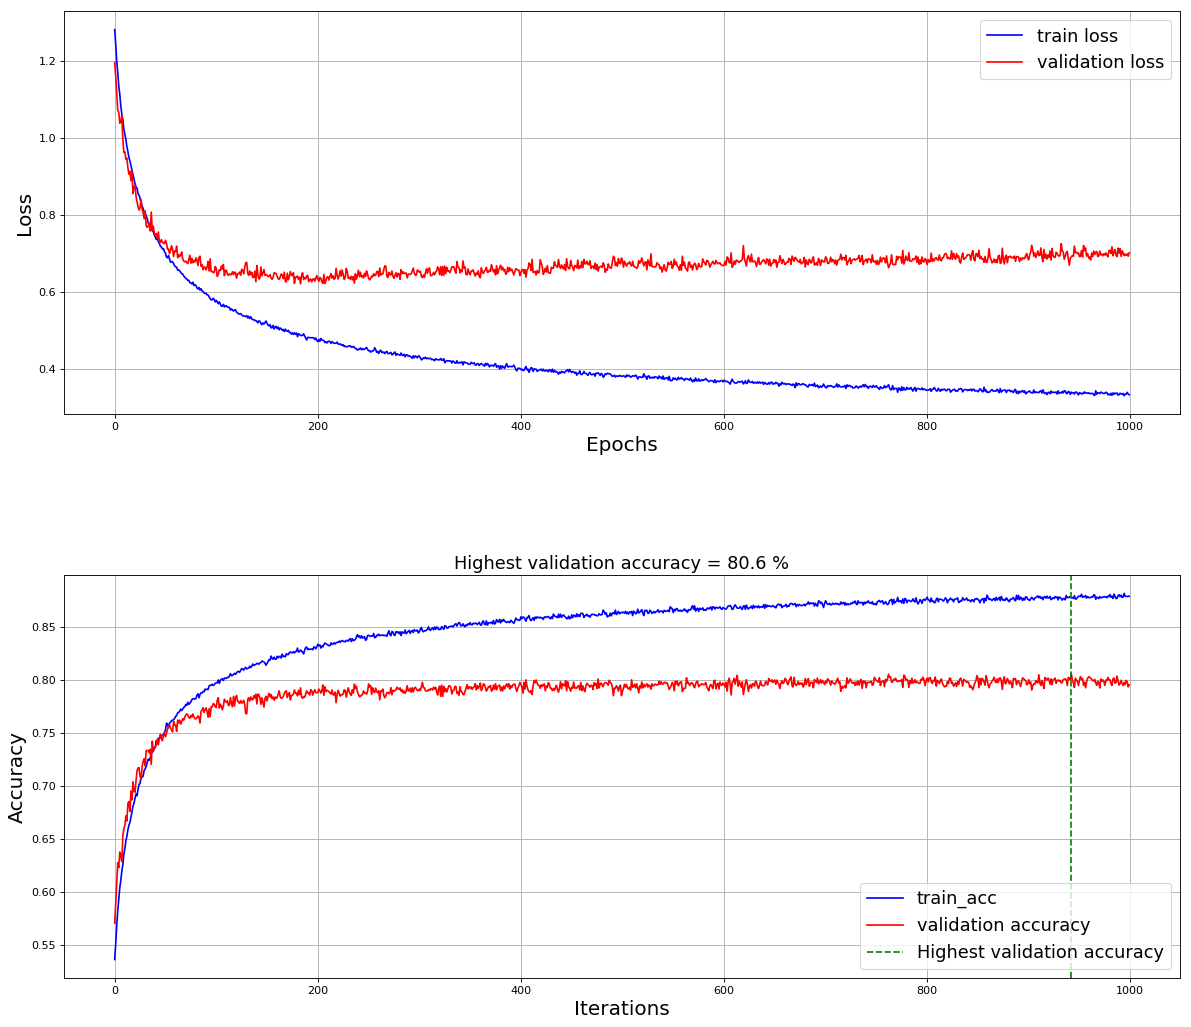

In [20]:
# Plot the training accuracy and the training loss
#plt.figure()
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(2, 1, 1)
# plt.subplots_adjust(hspace=2)
ax.plot(train_loss, 'b', label='train loss')
ax.plot(val_loss, 'r', label='validation loss')
ax.grid()
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
ax.legend(loc='upper right', fontsize=16)

ax = plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0.4)
ax.plot(train_acc, 'b', label='train_acc')
ax.plot(val_acc, 'r', label='validation accuracy')
ax.grid()
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
val_acc_max = np.max(val_acc)
val_acc_max_ind = np.argmax(val_acc)
plt.axvline(x=val_acc_max_ind, color='g', linestyle='--', label='Highest validation accuracy')
plt.title('Highest validation accuracy = %0.1f %%' % (val_acc_max*100), fontsize=16)
ax.legend(loc='lower right', fontsize=16)
plt.ion()

# TODO
#
# Seems to be overfitting
# Include dropout
# Increase dimentions and n_filters